# <center> Статистические тесты в контексте EDA. 
## <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Бизнес проблема.

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа мы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

- Если мы найдём в данных интересные закономерности, также отметьтим их в своём анализе.

Продемонстрируем использование разных тестов для проверки статистической значимости сделанных выводов:

- тесты для количественного признака:
    - для одной выборки;
    - для двух выборок;
    - для нескольких выборок;
- тест для категориальных признаков.

Мы будем использовать уровень значимости $\alpha$ - порог для оценки результата как статистически значимого. Если показатель значимости будет ниже уровня значимости, результат будет считается статистически значимым. 

__На каждый вопрос мы будем отвечать с уровнем значимости $\alpha=0.05$.__

Это значит, что вероятность случайного получения статистически значимого результата составляет менее 5% - т.е мы готовы в 5% допустить ошибку 1 рода - сделать вывод, что эффект есть, хотя на самом деле его нет.

Ошибка 1 рода - вероятность отклонить нулевую гипотезу, когда она верна.
***

У нас есть датасет с данными о зарплате в сфере Data Science за 2020–2022 годы. Датасет содержит следующие столбцы-параметры.

- work_year - Год, в котором была выплачена зарплата.
- experience_level - Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
- employment_type - Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
- job_title - Роль, в которой соискатель работал в течение года.
- salary - Общая выплаченная валовая сумма заработной платы.
- salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
- salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
- employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
- remote_ratio - Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
- company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
- company_size - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

### Imports
Import libraries and write settings.

In [934]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels import stats as sms
from wordcloud import WordCloud
import country_converter as coco

# Parse URLs into components and work's it
import urllib.parse as req


# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set aspects of the visual theme
sns.set_theme("notebook") # установка предварительных настроек маштабирования
sns.set_palette("husl") # установка предварительной световой палитры
# Размер столбцов
px.update_traces(width=0.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: module 'plotly.express' has no attribute 'update_traces'

In [2]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


# Analysis/Modeling

### Исследование структуры данных.

In [3]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.zip')
display(data)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [4]:
# Посмотрим размерность данных
display(data.shape)

(607, 12)

In [5]:
# Оценим информацию о датафрейме
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


None

In [6]:
# Посмотрим статистическую информацию по всем столбцам
display(data.describe(include = 'all'))

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,607.000000,607.000000,607,607,607,6.070000e+02,607,607.000000,607,607.00000,607,607
unique,NaN,NaN,4,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,NaN,SE,FT,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,NaN,280,588,143,NaN,398,NaN,332,NaN,355,326
mean,303.000000,2021.405272,NaN,NaN,NaN,3.240001e+05,NaN,112297.869852,NaN,70.92257,NaN,NaN
std,175.370085,0.692133,NaN,NaN,NaN,1.544357e+06,NaN,70957.259411,NaN,40.70913,NaN,NaN
min,0.000000,2020.000000,NaN,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.00000,NaN,NaN
25%,151.500000,2021.000000,NaN,NaN,NaN,7.000000e+04,NaN,62726.000000,NaN,50.00000,NaN,NaN
50%,303.000000,2022.000000,NaN,NaN,NaN,1.150000e+05,NaN,101570.000000,NaN,100.00000,NaN,NaN
75%,454.500000,2022.000000,NaN,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.00000,NaN,NaN


In [7]:
# Поищем дубликаты. Предварительно создадим список столбцов dupl_columns, по которым 
# будем искать совпадения (все столбцы, не включая Unnamed: 0, т.к. он задает каждой 
# строке свой уникальный индентификатор, дублируя индекс). 
dupl_columns = list(data.columns)
dupl_columns.remove('Unnamed: 0')
# Создадим маску дубликатов с помощью метода duplicated() и произведём фильтрацию. 
# Результат заносим в переменную data_duplicates. Выведем число строк.
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 42


In [8]:
# Посмотрим пропуски
display(data.isnull().sum())

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

<hr style="border-style: dashed;">

У нас есть датасет со следующими данными:   
- размерность 607 строк и 12 параметров (столбцов)
- 4 параметров числовых: Unnamed: 0, work_year, salary, salary_in_usd, remote_ratio
- 8 категориальных: - remote_ratio, experience_level, employment_type, job_title, salary_currency, employee_residence, company_location, company_size
- в датасете 42 дубликата
- пропусков у нас нет

__Вывод__:  
Нам надо будет удалить параметр - 'Unnamed: 0', так как он не представляет для нас ценности и представляет из себя идентификатор строк датафрейма. Также надо удалить 42 найденных дубликата. Возможно нам надо будет перекодировать категориальные данные при более близком знакомстве с ними. При более близком знакомстве с параметрами возможно, еще что то удалим (кандидаты - salary, salary_currency) 
<hr style="border-style: dashed;">

In [9]:
# Удаляем столбец, дубликаты и сбросим индексы
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop_duplicates(subset=dupl_columns)
data = data.reset_index(drop=True)
print('Размер таблицы после удаления: {}'.format(data.shape))

Размер таблицы после удаления: (565, 11)


# <center> Проведем одномерный анализ данных

Мы исследуем каждый столбец и посмотрим распределение данных и другую информацию которую сможем найти. 
Сначала исследуем числовые данные, затем категориальнные.
    
## <center> Числовые данные

- work_year
- salary 
- salary_in_usd

    
#### Распределение выплат DS (salary_in_usd)
    
Так как нам надо сравнивать данные с выплатами, то изучим общее распределение выплат DS, как они располагаються с точки зрения наблюдений. Изучать мы будем столбец - __salary_in_usd__, так как здесь выплаты приведенны к обшему знаменателю.
Так как, мы хотим посмотреть распределение числового признака, то воспользуемся гистограммой.

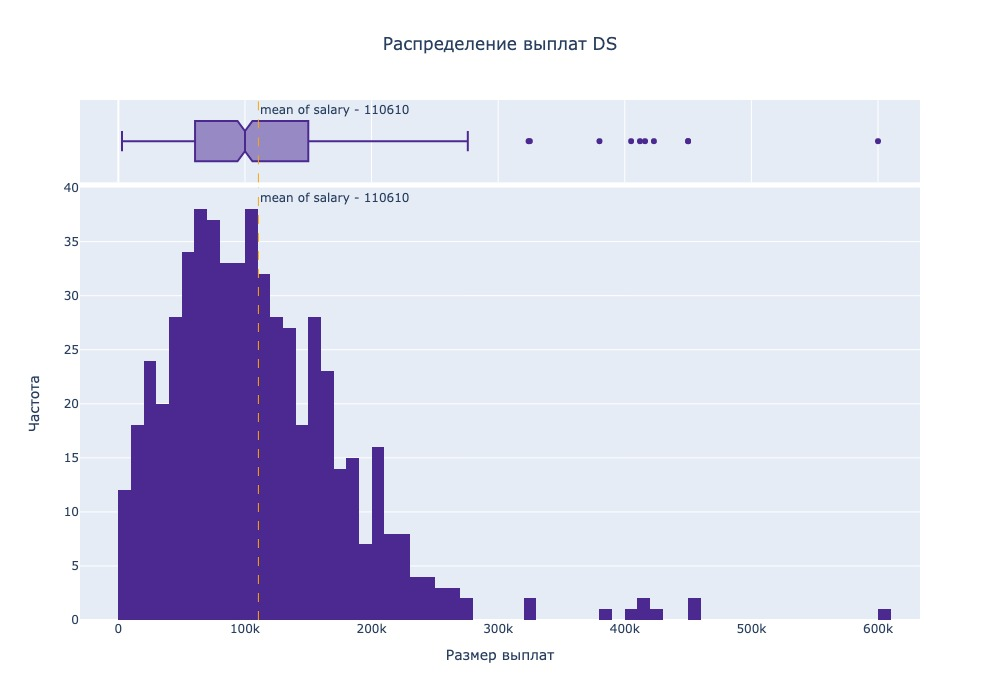

In [940]:
# Так как у нас выплаты приведенны в разных валютах, у нас есть параметр который
# приводит все выплаты в долларах - воспользуемся им.
fig = px.histogram(data, 
                    nbins=100,
                    x="salary_in_usd",
                    title="Распределение выплат DS",
                    color_discrete_sequence=px.colors.sequential.Agsunset,
                    width = 1000, 
                    height = 700, 
                    marginal='box',
                )

# Нарисуем линию среднего salary_in_usd
fig.add_vline(x=data['salary_in_usd'].mean(), 
              line_width=1,
              line_dash="dash", 
              annotation_text = 'mean of salary - 110610', 
              line_color="orange")

# Обновим данные для осей и названия
fig.update_layout(title_x = 0.5,
                    xaxis_title="Размер выплат", 
                    yaxis_title="Частота",
                  )

fig.show('jpeg')
#fig.write_html("data/plotly/001_scheduling_salary_histogram.html")

In [939]:
# Посмотрим числовые характеристики и преобразуем в датафрейм
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер выплат в USD']
display(data_agg)

,Размер выплат в USD
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


<hr style="border-style: dashed;">

__Вывод:__
- Распределение у нас ненормальное как видно по графику, не совпадает медианна (100 тысяч) и среднее (среднее - пунктирная оранжевая линия 110610)  
- Крайние значения: слева - 2859, справа - 600 тысяч.
- Присутствуют выбросы
- Основная масса получают от 60.5 тысяч до 150 тысяч долларов

Здесь видимо сказываються множество факторов на выплаты - опыт, должность и т.д. Более внимательно изучим это ниже.

<hr style="border-style: dashed;">

#### Год, в котором была выплата (work_year).

In [929]:
# Посмотрим признак
salary_year = data['work_year'].value_counts()
display(salary_year)

2022    278
2021    215
2020     72
Name: work_year, dtype: int64

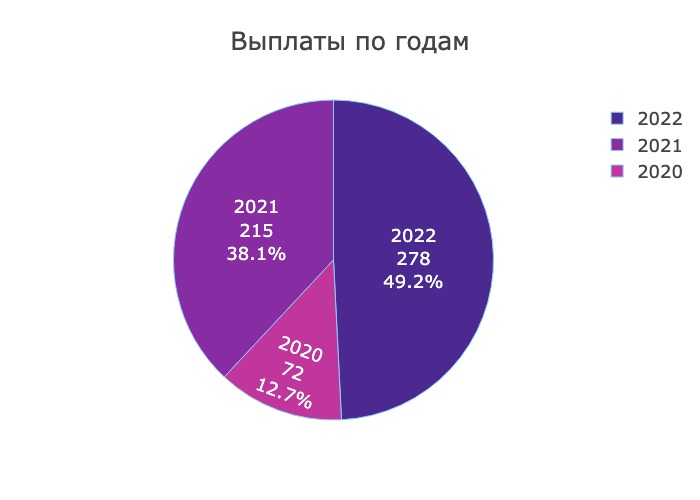

In [941]:
# Посмотрим пропорцию годов - выберем круговую диаграмму 
fig = px.pie(values=salary_year.values, 
             names=salary_year.index, 
             color_discrete_sequence=px.colors.sequential.Agsunset,
             title= 'Выплаты по годам',
             template='presentation'
            )

# Текст на графике
fig.update_traces(textinfo='label+percent+value', 
                  textfont_size=18,
                  marker=dict(line=dict(color='lightskyblue',
                                        width=1
                                       )
                             )
                 )

fig.show('jpeg')
#fig.write_html("data/plotly/002_salary_year_pie.html")

<hr style="border-style: dashed;">

__Вывод:__   
Как видим около половины у нас занимает 2022 год, затем идет 2021 и замыкает 2020.

Могу предположить, что с 2020 года начался рост популярности профессий DS и начали массово набирать специалистов.
<hr style="border-style: dashed;">

#### Общая выплаченная валовая сумма  (salary)    
Данный столбец у нас также отражает выплаты, но здесь есть нюанс, он отражает их в разных валютах. А валюты у нас храняться в категориальном столбце (salary_currency). 

In [931]:
# Посмотрим числовые характеристики
data_agg = data['salary'].describe().round(2).to_frame()
data_agg.columns = ['Размер выплат']
display(data_agg)

,Размер выплат
count,565.00
mean,338115.99
std,1599878.79
min,4000.00
25%,67000.00
50%,110925.00
75%,165000.00
max,30400000.00


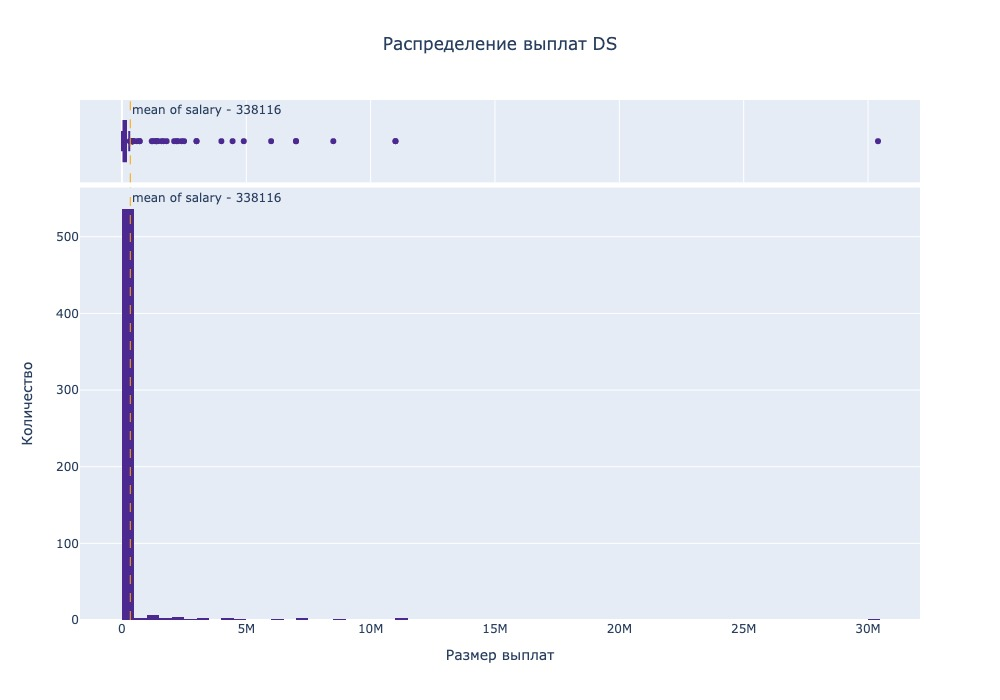

In [942]:
# Посмотрим распределение числового признака - выебрем гистограмму
fig = px.histogram(data, 
                    nbins=100,
                    x="salary",
                    title="Распределение выплат DS",
                    width = 1000, 
                    height = 700, 
                    color_discrete_sequence=px.colors.sequential.Agsunset,
                    marginal='box',
                )

# Нарисуем линию среднего salary
fig.add_vline(x=data['salary'].mean(), 
              line_width=1, 
              line_dash="dash", 
              annotation_text = 'mean of salary - 338116', 
              line_color="orange")

# Обновим данные для осей и названия
fig.update_layout(title_x = 0.5,
                    xaxis_title="Размер выплат", 
                    yaxis_title="Количество",
                 )


fig.show('jpeg')
#fig.write_html("data/plotly/003_scheduling_salary_histogram.html")

<hr style="border-style: dashed;">

__Вывод:__   
- Как мы видим распределение не нормальное, медианна (110.9 тысяч) не совпадает со средним (338.1 тысяч)
- Крайние значения: слева - 4000, справа - 30.4 миллиона

Скорее всего данный столбец мы удалим, если будем использовать данные в машинном обучение, так как он будет избыточным для нас

<hr style="border-style: dashed;">


## <center> Категориальные данные

- remote_ratio
- experience_level
- employment_type
- job_title
- salary_currency
- employee_residence
- company_location
- company_size


#### Общий объём работы, выполняемой удалённо (remote_ratio).

Этот столбец представелен числовыми данными, но на самом деле здесь 'зашифрованны' категориальные данные 

Возможные значения:
- 0 — удалённой работы нет (менее 20 %);
- 50 — частично удалённая работа;
- 100 — полностью удалённая работа (более 80 %).

Здесь как мы видим у нас есть 3 значения, которые обозначают сколько процентов работы приходиться выполнять удалленно.

In [16]:
# Посмотрим признак
remote_ratio = data['remote_ratio'].value_counts(ascending=True)
display(remote_ratio)

50      98
0      121
100    346
Name: remote_ratio, dtype: int64

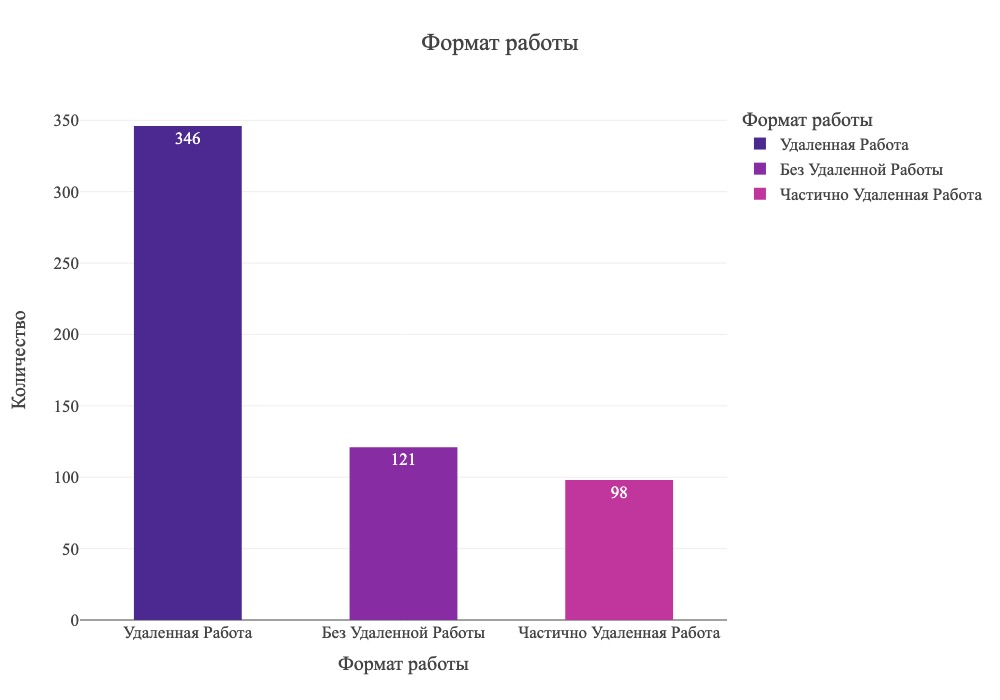

In [944]:
# Сравним наши данные визуально - используем для этого - столбчатую диаграмму
# Расшифруем категории для отображения столбцов работы и применим
work_type = ['Удаленная Работа', 'Без Удаленной Работы', 'Частично Удаленная Работа',]
# Графика
fig = px.bar(x = work_type, 
            y = data['remote_ratio'].value_counts().values,
            color = work_type,
            height=700, 
            width=1000,
            color_discrete_sequence=px.colors.sequential.Agsunset,
            text=data['remote_ratio'].value_counts().values,
            title = 'Формат работы',
            template='presentation',
            labels={'color':'Формат работы'}
            )

# Обновим шрифт и оси графика
fig.update_layout(
    xaxis_title="Формат работы",
    yaxis_title="Количество",
    font = dict(size=17,family="TimesNewRoman"))

# Обновим размер столбцов
fig.update_traces(width=0.5)

fig.show('jpeg')
#fig.write_html("data/plotly/004_remote_ratio_bar.html")

<hr style="border-style: dashed;">

__Вывод:__   
Из графика мы видим, что большая часть работ выполняються удаленно. Скорее всего это связанно с наличием хорошего интернет-доступ, могу предположить, что возможно много DS работают в заграничных компаниях (учитывая разные валюты оплаты) из дома.

<hr style="border-style: dashed;">
    
#### Опыт работы на этой должности в течение года (experience_level)

Возможные значения:
- EN — Entry-level/Junior;
- MI — Mid-level/Intermediate;
- SE — Senior-level/Expert;
- EX — Executive-level/Director.

In [945]:
# Посмотрим данные
experience_level = data['experience_level'].value_counts()
display(experience_level)

SE    243
MI    208
EN     88
EX     26
Name: experience_level, dtype: int64

In [946]:
# Посмотрим данные в процентном соотношение
exp_level=(data['experience_level'].value_counts(normalize=True)*100).round(2)
display(exp_level)

SE    43.01
MI    36.81
EN    15.58
EX     4.60
Name: experience_level, dtype: float64

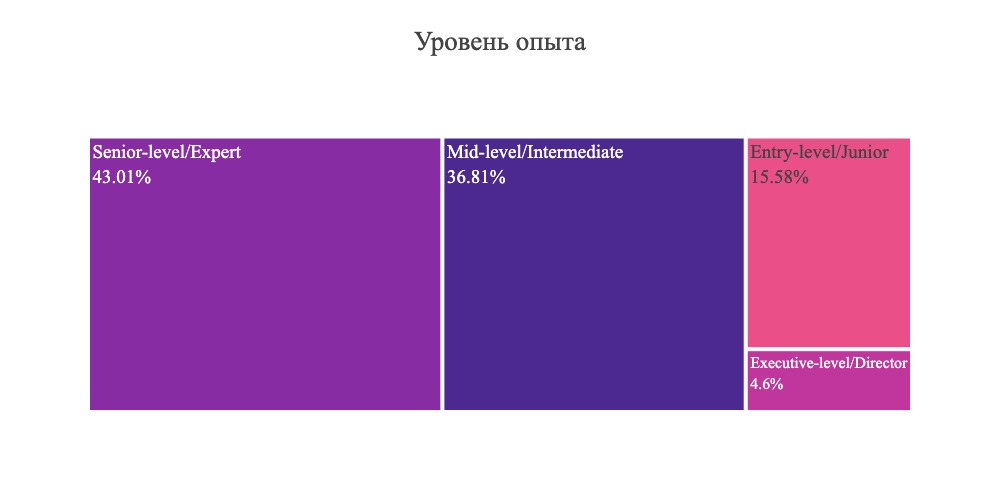

In [947]:
# Посмотрим визуально на пропорций уровней опыта - используем иерархическую диаграмму
# Для более корректного представления расшифруем сокращения должности,  заменив индексы
exp_level.index = (['Senior-level/Expert', 
                    'Mid-level/Intermediate',
                    'Entry-level/Junior', 
                    'Executive-level/Director'
                   ])

# График
fig = px.treemap(exp_level, 
                    path=[exp_level.index],
                    values=exp_level.values, 
                    title = 'Уровень опыта',
                    color=exp_level.index,
                    color_discrete_sequence=px.colors.sequential.Agsunset,
                    template='presentation',
                    width=1000, 
                    height=500
                )

# Текст на графике
fig.data[0].texttemplate = '%{label}<br>%{value}%'

fig.update_layout(
    font=dict(size=19,family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/005_experience_level_treemap.html")

<hr style="border-style: dashed;">

__Вывод:__    
Как видим 43% это специалисты уровня Senior - можем предположить, что они закрывают большинство вопросов в данной сфере, могут работать в одиночку, без команды. Далее у нас идет Midle, около 37%. Начинающих у нас 15.5% здесь скорее всего они только пришли в какие либо команды, либо выплняют низкооплачиваемые и простые заказы. Насчет директоров 4.6% - здесь работа в компаниях (командах), выполнение роли тимлида?

<hr style="border-style: dashed;">

#### Тип занятости (employment_type)

Возможные варианты: 

- PT — неполный рабочий день
- FT — полный рабочий день
- CT — контракт
- FL — фриланс

In [948]:
# Посмотрим признак
type_of_employment = data['employment_type'].value_counts()
display(type_of_employment)

FT    546
PT     10
CT      5
FL      4
Name: employment_type, dtype: int64

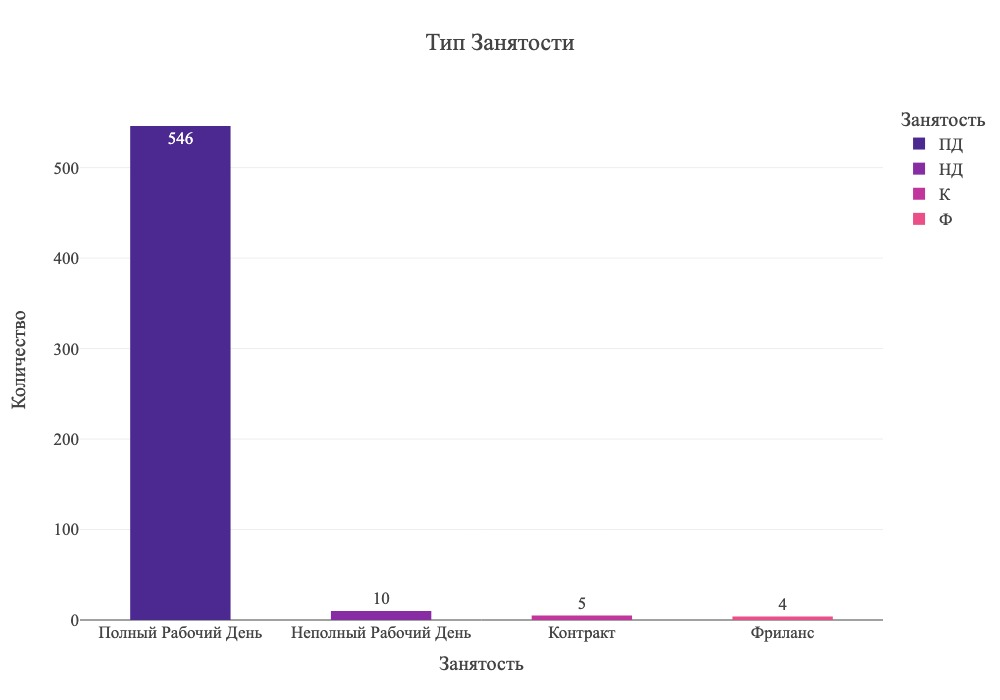

In [949]:
# Сравним наши данные визуально - используем для этого - столбчатую диаграмму
# Расшифруем сокращения занятости, заменив индексы
employment_type = ['Полный Рабочий День', 
                   'Неполный Рабочий День', 
                   'Контракт', 
                   'Фриланс']

# Для легенды обозначим сокращения
acronym = ['ПД', 'НД', 'К', 'Ф']

# График
fig = px.bar(x = employment_type, 
            y = type_of_employment.values, 
            color = acronym, 
            color_discrete_sequence=px.colors.sequential.Agsunset,
            template = 'presentation',
            text = type_of_employment.values, 
            title = 'Тип Занятости',
            labels = {'color':'Занятость'},
            height = 700, 
            width = 1000
            )

# Название осей и шрифт
fig.update_layout(xaxis_title="Занятость",
                yaxis_title="Количество",
                font = dict(size=17,
                            family="TimesNewRoman"
                           )
                 )

# Обновим размер столбцов
fig.update_traces(width=0.5)

fig.show('jpeg')
#fig.write_html("data/plotly/006_employment_type_bar.html")

<hr style="border-style: dashed;">

__Вывод:__    
Как видим подавляющее большиство DS работают полный рабочий день, у 10 неполный рабочий день - возможно совмещают. На контракте у нас всего 5 человек - возможно директора ? И в свободном плавание 4 специалиста - здесь есть варинаты как джуны так и сеньоры. 

<hr style="border-style: dashed;">

#### Роль, в которой соискатель работал в течение года (job_title)

Здесь видимо имеется ввиду должность сотрудника.

In [1081]:
# Посмотрим на данные
job_title = data['job_title'].value_counts().to_frame()
display(job_title)

,job_title
Data Scientist,130
Data Engineer,121
Data Analyst,82
Machine Learning Engineer,39
Research Scientist,16
...,...
Big Data Architect,1
Finance Data Analyst,1
Marketing Data Analyst,1
Machine Learning Manager,1


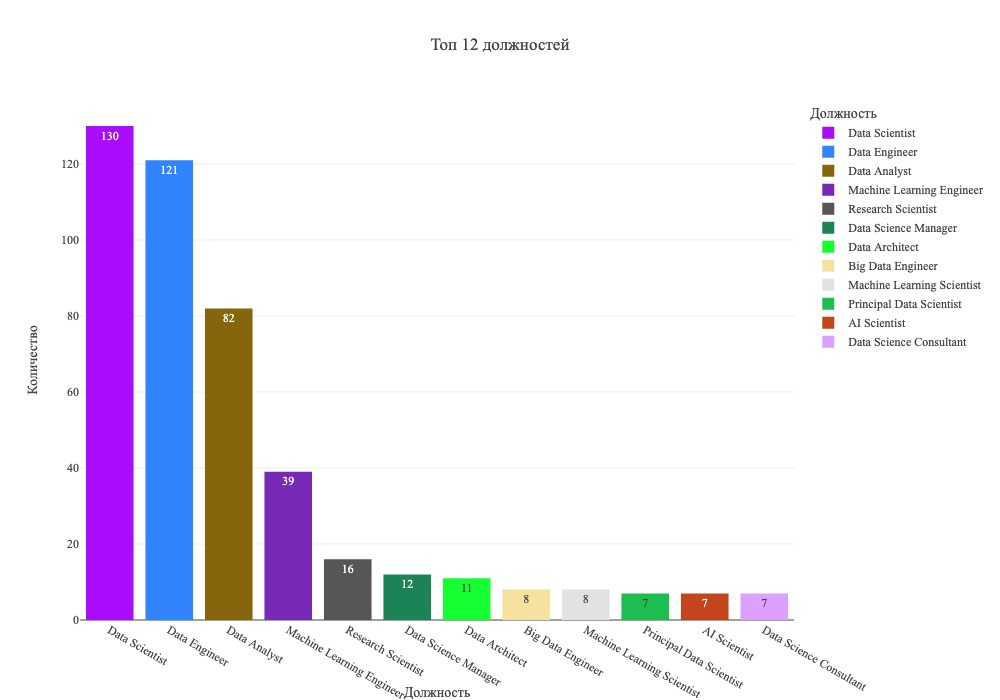

In [952]:
# Посмотрим наши структуру данных визуально - воспользуемся столбчатой диаграммой  
# Так как у нас 50 должностей, то мы посмотрим топ 12
job_title_top12 = data['job_title'].value_counts()[:12]

# График
fig = px.bar(x = job_title_top12.index, 
                y = job_title_top12.values,
                color = job_title_top12.index,
                color_discrete_sequence=px.colors.qualitative.Alphabet,
                text = job_title_top12.values,
                title = 'Топ 12 должностей',
                template = 'presentation',
                height = 700, 
                width = 1000,
                labels={'color':'Должность'}
            )

# Настройки шрифта и названия осей
fig.update_layout(xaxis_title="Должность",
                    yaxis_title="Количество",
                    font = dict(size=12,family="TimesNewRoman")
                 )

fig.show('jpeg')
#fig.write_html("data/plotly/007_job_title_bar.html")

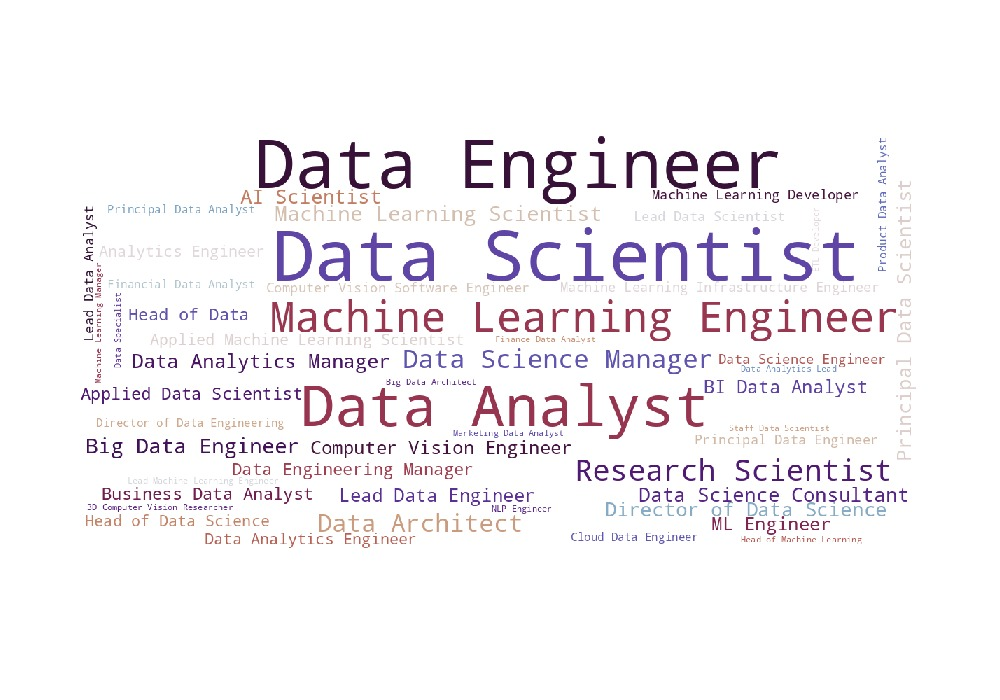

In [25]:
# Для того, чтобы полностью охватить все должности и понять какие из них наиболее 
# популярны сделаем облако слов
# Генерируем и настраиваем облако слов и сохраняем в переменной cloud
cloud = WordCloud(width=1200, 
                    height=600, 
                    max_words=50,
                    colormap='twilight',
                    max_font_size = 100,
                    random_state=88, 
                    background_color='white'
                ).generate_from_frequencies(job_title)

# Выводим облако на экран
fig = px.imshow(cloud,
                height = 700, 
                width = 1000
               )

# Отключаем отображение оси координат
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.show('jpeg')
#fig.write_html("data/plotly/008_job_title_WordCloud.html")

<hr style="border-style: dashed;">

__Вывод:__   
- 50 должностей
- топ 4: Data Scientist, Data Engineer, Data Analyst, Machine Learning Engineer - составляют больше 50% количества должностей

Думаю топ 4 это основа DS - другие должности уже служат надстройкой, с учетом углубления в какую либо специализацию либо специфику места работы. А эти 4 должности наиболее востребованные.

<hr style="border-style: dashed;">

#### Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217 (salary_currency)

In [953]:
# Посмотрим данные
salary_currency = data['salary_currency'].value_counts()
display(salary_currency)

USD    359
EUR     93
GBP     43
INR     27
CAD     18
JPY      3
PLN      3
TRY      3
CNY      2
MXN      2
HUF      2
DKK      2
SGD      2
BRL      2
AUD      2
CLP      1
CHF      1
Name: salary_currency, dtype: int64

In [954]:
# Перед тем как построить графики и посмотреть визуально расшифруем обозначения валют 
# Спарсим таблицу и объединим с salary_currency, у нас есть ссылка на валюты, но там
# присуствует кирилица 
# Считываем наш URL
codes_ru = req.urlparse('https://ru.wikipedia.org/wiki/\
                                                    Коды_и_классификаторы_валют')

# Мы считали данные, они у нас бъются на 6 параметров (индексов), смотрим какой нам
# надо изменить (параметр path (индекс 2))
display(codes_ru)

# С помощью quote заменяем специальные символы (кирилицу) на ASCII символы 
update = req.quote(codes_ru[2])

# Здесь используем конструктор urljoin он находит соответсвия в параметрах и 
# конструирует URL заново вместе с преобразованным параметром
url = req.urljoin('https://ru.wikipedia.org/wiki/Коды_и_классификаторы_валют',
                                                                      update)

# Считываем URL страницу
tableau = pd.read_html(url)

# Просмотрев информацию мы определили что нужная нам информация находится в индексе 1
codes_ru = tableau[0]

# Так как вся информация из таблицы нам не нужна вытащим интересующую нас
codes_ru_01 = pd.DataFrame(codes_ru['Наименование валюты']
                           ['в соответствии с ОКВ[8]']
                           ['Существующие валюты, включённые в стандарт ISO 4217'])
codes_ru_02 = pd.DataFrame(codes_ru['ISO 4217']['alfa-3']
                           ['Существующие валюты, включённые в стандарт ISO 4217'])

# Переименнуем название столбцов
codes_ru_01.columns = ['Название валюты, ISO 4217']
codes_ru_02.columns = ['Обозначение валюты, ISO 4217']

# Объединим стобцы в одну таблицу
codes_ru = pd.concat([codes_ru_01, codes_ru_02], axis=1)

# Преобразуем коды из оригинала в отдельную таблицу
currency = pd.DataFrame(data['salary_currency'])
# Cовместим таблицы по ключевому столбцу с помощью метода join(), используем ключевой
# столбец в «правой» таблице (codes) в качестве индекса, с помощью метода set_index()
# также укажем название ключа в параметре on.
joined = currency.join(codes_ru.set_index('Обозначение валюты, ISO 4217'),
                        on='salary_currency',
                        how='left'
                    )

display(joined)

ParseResult(scheme='https', netloc='ru.wikipedia.org', path='/wiki/                                                    Коды_и_классификаторы_валют', params='', query='', fragment='')

,salary_currency,"Название валюты, ISO 4217"
0,EUR,Евро
1,USD,Доллар США
2,GBP,Фунт стерлингов
3,USD,Доллар США
4,USD,Доллар США
...,...,...
560,USD,Доллар США
561,USD,Доллар США
562,USD,Доллар США
563,USD,Доллар США


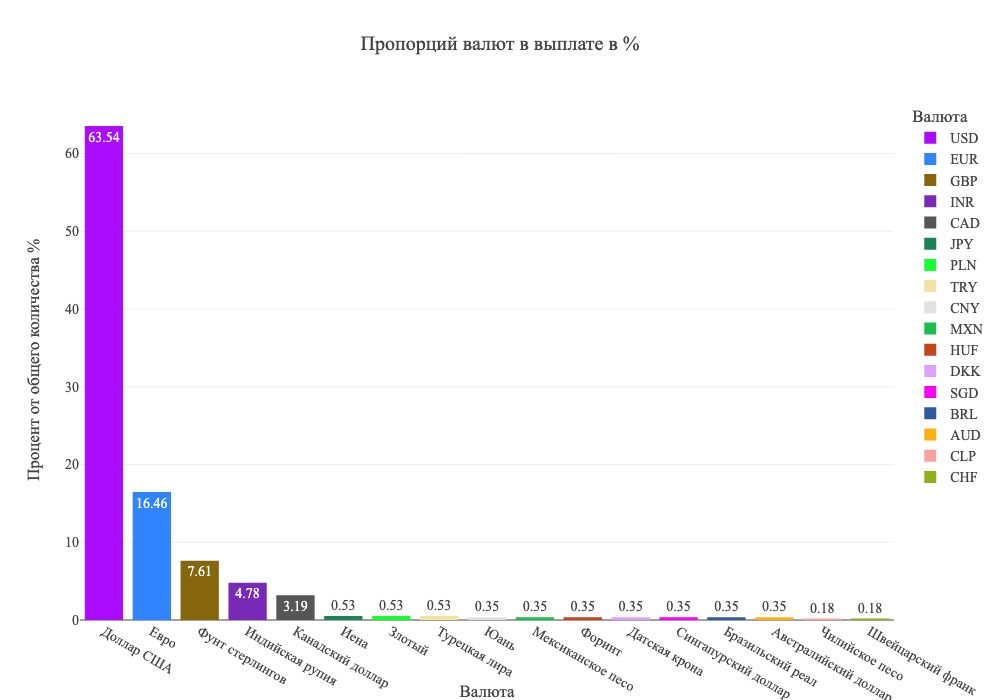

In [1069]:
# Сравним количество выплат в разных валютах - используем bar.
# Подсчитаем количество валют в процентном соотношение
name_currency = (joined['Название валюты, ISO 4217'].value_counts(
                                            normalize=True) * 100).round(2)
# График# График
fig = px.bar(x = name_currency.index, 
            y = name_currency.values, 
            color = salary_currency.index, 
            color_discrete_sequence=px.colors.qualitative.Alphabet,
            template = 'presentation',
            text = name_currency.values, 
            title = 'Пропорций валют в выплате в %',
            labels = {'color':'Валюта'},
            height = 700, 
            width = 1000
            )

# Название осей и шрифт
fig.update_layout(xaxis_title="Валюта",
                yaxis_title="Процент от общего количества %",
                font = dict(size=14,family="TimesNewRoman"))


fig.show('jpeg')
#fig.write_html("data/plotly/009_salary_currency_treemap.html")

<hr style="border-style: dashed;">

__Вывод:__
- 17 валют
- Более 60% в выплатах занимает доллар.

Как видим у нас представленно 17 валют, топ 5 валют охватывают более 95,5%. Как видим большинство DS получают выплаты в долларах и евро, и скорее всего большинство проживает в США. Те кто получает выплаты в национальных валютах (кроме доллара США и евро), проживают на террриторий стран, где они в ходу. Евро и долларом США, могут выплачиваться и в странах за пределами США и ЕС (например в Россий или Китай), но это надо будет сопоставить с местом проживания.

<hr style="border-style: dashed;">

#### Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166 (employee_residence).

In [958]:
# Посмотрим на данные
employee_residence = pd.DataFrame(data['employee_residence'].value_counts())
display(employee_residence)

,employee_residence
US,295
GB,43
IN,30
CA,27
DE,24
...,...
BG,1
HR,1
PH,1
NZ,1


In [960]:
# Посмотрим визуально на карте где они располагаються.
# Для этого мы воспользуемся библиотекой country_converter и расшифруем сокращения
employee_residence['name_country'] = coco.convert(
                            names=employee_residence.index, to='name_short')
display(employee_residence)

1

,employee_residence,name_country
US,295,United States
GB,43,United Kingdom
IN,30,India
CA,27,Canada
DE,24,Germany
...,...,...
BG,1,Bulgaria
HR,1,Croatia
PH,1,Philippines
NZ,1,New Zealand


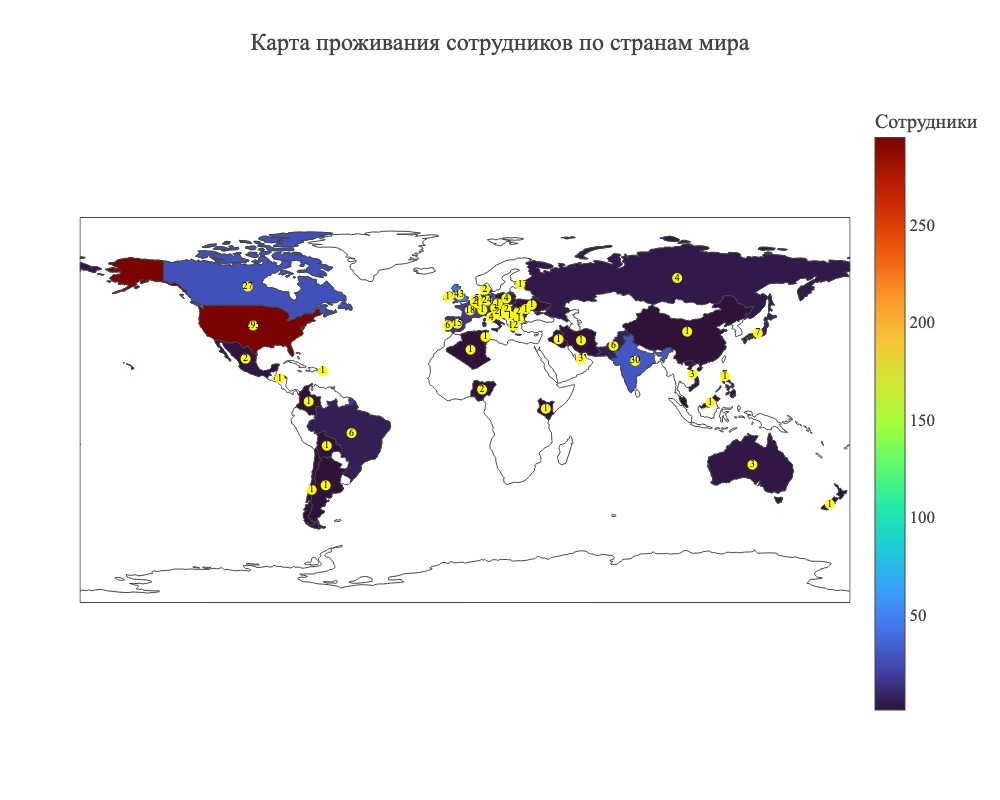

In [967]:
# График
fig = px.choropleth(locations = employee_residence['name_country'],
                    locationmode='country names',
                    color = employee_residence['employee_residence'],
                    color_continuous_scale = px.colors.sequential.Turbo,
                    template = 'presentation',
                    title = 'Карта проживания сотрудников по странам мира',
                    height = 800, 
                    width = 1000,
                    labels={'color':'Сотрудники'}
                   )

# Настройка отображений текста на карте
fig.add_scattergeo(locations = employee_residence['name_country'],
                    locationmode='country names',
                    text= employee_residence['employee_residence'], 
                    mode='markers+text',
                    textfont=dict(color='black',  
                                    size=10,       
                                ),
                   marker=dict(color='yellow',
                                    size=10
                                   ),
                    textposition='middle center',                   
                    )

# Настройки шрифта
fig.update_layout(font = dict(size= 17, family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/010_employee_residence_choropleth.html")

<hr style="border-style: dashed;">

__Вывод:__   
- 57 стран
- около 50% проживают в США

Как видим ареал обитания достаточно большой и согласуется с теми данными, что мы видели раньше по поводу оплаты. Большая часть проживает в США, что и неудивительно в принципе там это все зародилось и разваиваеться сейчас, ЕС также не отстает. Ареал обитания DS покрывает все континенты (кроме Антарктики), даже в Африке мы можем наблюдать наличие специалистов. Что характерно, мы видим есть страны, в которых DS не платят нац. валютой за работу, а платят видимо в других валютах, так как отстутствуют национальные коды валют данных стран (РФ, Китай и др.). 

<hr style="border-style: dashed;">

#### Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166 (company_location)

In [962]:
# Посмотрим на данные и для облегчения восприятия расшифруем
company_location = pd.DataFrame(data['company_location'].value_counts())
company_location['name_country'] = coco.convert(
                            names=company_location.index, to='name_short')
display(company_location)

,company_location,name_country
US,318,United States
GB,46,United Kingdom
CA,28,Canada
DE,27,Germany
IN,24,India
...,...,...
HR,1,Croatia
NZ,1,New Zealand
HU,1,Hungary
HN,1,Honduras


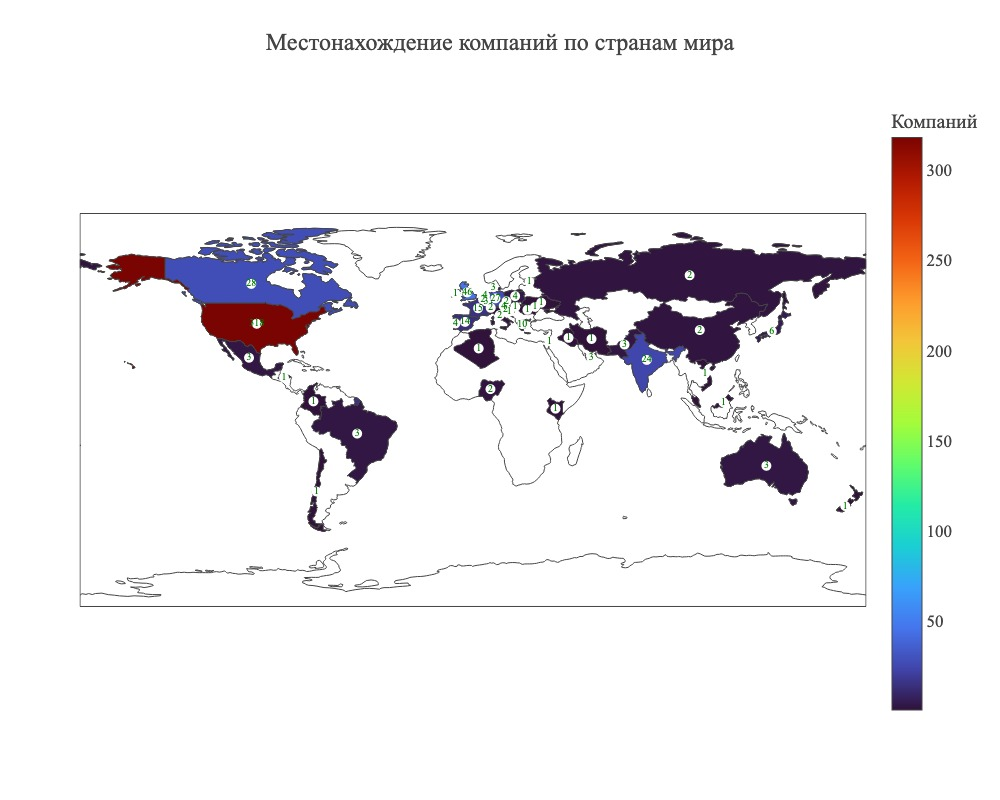

In [968]:
# График
fig = px.choropleth(locations = company_location['name_country'],
                    locationmode='country names',
                    color = company_location['company_location'],
                    color_continuous_scale = px.colors.sequential.Turbo,
                    template = 'presentation',
                    title = 'Местонахождение компаний по странам мира',
                    height = 800, 
                    width = 1000,
                    labels={'color':'Компаний'}
                   )

# Настройка отображений текста на карте
fig.add_scattergeo(locations = company_location['name_country'],
                    locationmode='country names',
                    text= company_location['company_location'], 
                    mode='markers+text',
                    textfont=dict(color='green',  
                                    size=10,       
                                ),
                   marker=dict(color='white',
                                    size=10
                                   ),
                    textposition='middle center',                   
                    )

# Настройки шрифта
fig.update_layout(font = dict(size= 17, family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/011_company_location_choropleth.html")

In [ ]:
__________________________________Ниже удалить_______________________

In [33]:
# Перед тем как построить графики и посмотреть визуально переведем названия 
# Для этого спарсим таблицу и объединим с company_location
# Считываем наш URL
country_ru = req.urlparse(
            'https://ru.wikipedia.org/wiki/Общероссийский_классификатор_стран_мира')

# Мы считали данные, они у нас бъются на 6 параметров (индексов), смотрим какой нам
# надо изменить (параметр path (индекс 2))
display(country_ru)

# С помощью quote заменяем специальные символы (кирилицу) на ASCII символы 
update = req.quote(country_ru[2])

# Здесь используем конструктор urljoin он находит соответсвия в параметрах и 
# конструирует URL заново вместе с преобразованным параметром
url = req.urljoin(
    'https://ru.wikipedia.org/wiki/Общероссийский_классификатор_стран_мира', update)

# Считываем URL страницу
tableau = pd.read_html(url)

# Просмотрев информацию, мы определили что нужная нам информация находится в индексе 0
country_ru = tableau[0]

# Так как вся информация из таблицы нам не нужна вытащим интересующую нас
country_ru_01 = pd.DataFrame(country_ru['Наименование страны']['Краткое'])
country_ru_02 = pd.DataFrame(country_ru['Код']['2-букв.'])

# Объединим стобцы в одну таблицу
country_ru = pd.concat([country_ru_01, country_ru_02], axis=1)

# Cовместим таблицы по ключевому столбцу с помощью метода join(), используем ключевой
# столбец в «правой» таблице (company_location) в качестве индекса, 
# с помощью метода set_index() также укажем название ключа в параметре on.
joined_ru = company_location.join(country_ru.set_index('2-букв.'),
                                    on = company_location.index,
                                    how='left'
                                )

ParseResult(scheme='https', netloc='ru.wikipedia.org', path='/wiki/Общероссийский_классификатор_стран_мира', params='', query='', fragment='')

In [68]:
# Посмотрим вклад стран в количество компаний визуально, топ 10 и добавим категорию
# Выделяем ТОП-10 и добавляем категорию 'other'
joined_ru_1 = joined_ru[:9]
joined_ru_2 = pd.DataFrame(joined_ru['company_location'][9:].sum(), columns=[
            'company_location', 'name_country', 'Краткое'], index=['OTHER'])
joined_ru_2[['name_country', 'Краткое']] = 'Other', 'Другие'

# Объединим таблицы
joined_ru = pd.concat([joined_ru_1, joined_ru_2], axis = 0)

# Для корректного отображения сократим Соединенные Штаты (США) и 
# Соединенное Королевство (АНГЛИЯ)
joined_ru.loc['US','Краткое'] = 'США'
joined_ru.loc['GB','Краткое'] = 'АНГЛИЯ'
company_location_top = joined_ru

# Так как мы хотим сравнить страны по количеству компаний - испольузем bar диаграмму
# График 
fig = px.bar(y = company_location_top['company_location'], 
             x = company_location_top['Краткое'], 
             color = company_location_top['Краткое'],
             color_discrete_sequence=px.colors.qualitative.Alphabet,
             text=company_location_top['company_location'],
             title= 'Top 10 Стран по количеству компаний',
             template= 'presentation',
             labels = {'color':'Страны'},
             height = 800, 
             width = 1000
            )

# Название осей и шрифт
fig.update_layout(
    xaxis_title="Страны",
    yaxis_title="Количество",
    font = dict(size=17,family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/011_company_location_bar.html")

In [964]:
____________________  Выше удалить_______________

SyntaxError: invalid syntax (2294099127.py, line 1)

In [969]:
# Посмотрим в каких странах нет компаний, но там проживают специалисты, 
# а также в каких странах не проживают специалисты, но там есть компаний
# Создадим два списка, также объединим наши индексы стран через множество 
# и посмотрим отсутствие индексов в оригинальных списках
not_company = []
not_employee = []
for x in set(list(company_location.index) + list(employee_residence.index)):
    if x not in company_location.index:
        not_company.append(employee_residence['name_country'].loc[x])
    elif x not in employee_residence.index:
        not_employee.append(company_location['name_country'].loc[x])
    else:
        pass

print(f'Страны в которых проживают специалисты, но нет компаний:\n{not_company}')
print('------------------------------\n------------------------------')
print(f'Страны в которых есть компаний, но не проживают специалисты:\n{not_employee}')

Страны в которых проживают специалисты, но нет компаний:
['Jersey', 'Bulgaria', 'Philippines', 'Tunisia', 'Bolivia', 'Argentina', 'Serbia', 'Puerto Rico', 'Hong Kong']
------------------------------
------------------------------
Страны в которых есть компаний, но не проживают специалисты:
['Israel', 'American Samoa']


<hr style="border-style: dashed;">

__Вывод:__
- 50 стран
- большая часть компаний (318) находиться в США

Как мы видим у нас здесь стран поменьше, чем в когда мы смотрели страны проживания специалистов, но тем не менее 50 стран. Мы видим, что больше половины компаний находяться в США, затем следует Европа, Индия и остальные страны. Европа и Америка генерируют, очень большой объем информаций, который надо обрабатывать и применять в 'жизни'.    
Странно, что здесь у Китая отмеченно всего 2 компаний, думаю их скорее всего намного больше, у России также всего 2 компаний.

Также хочу отметить, что количество зарегистрированных в США фирм, превышает количество проживающих в США DS-специалистов.   
Мы видим расхождение в количестве стран проживания специалистов - 57 и количестве стран в которых зарегестрированны фирмы - 50. Что может подтверждать гипотезу о работе на удаленке на зарубежную компанию и соответственно оплату в нац. валюте головного офиса. С последующей конвертацией по текушему курсу ? 

<hr style="border-style: dashed;">

#### Среднее количество людей, работавших в компании в течение года (company_size)

Возможные варианты:

- S — менее 50 сотрудников (небольшая компания)
- M — от 50 до 250 сотрудников (средняя компания)
- L — более 250 сотрудников (крупная компания)

In [970]:
# Посмотрим признак
company_size = pd.DataFrame(data['company_size'].value_counts())
display(company_size)

,company_size
M,290
L,193
S,82


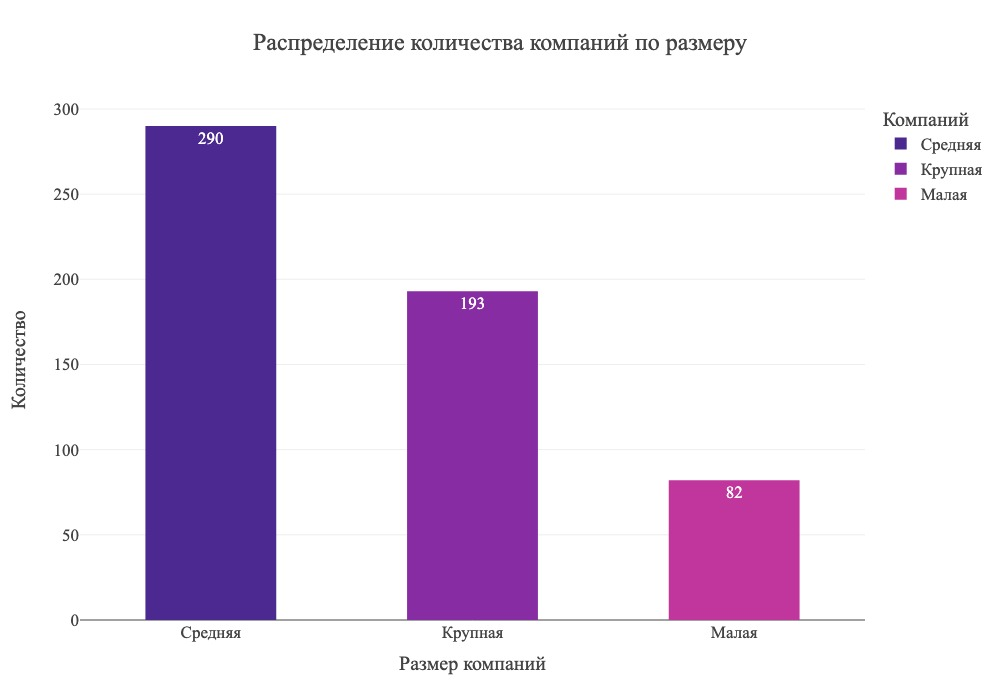

In [972]:
# Для графической наглядности расшифруем данные и отобразим на графике 
company_size.loc['M', 'decoding'] = 'Средняя'
company_size.loc['L', 'decoding'] = 'Крупная'
company_size.loc['S', 'decoding'] = 'Малая'

# Снова сравним данные по количеству компаний - воспользуемся снова bar диаграммой
fig = px.bar(x = company_size['decoding'],
                y = company_size['company_size'], 
                color = company_size['decoding'],
                color_discrete_sequence = px.colors.sequential.Agsunset,
                text = company_size['company_size'],
                title = 'Распределение количества компаний по размеру',
                template = 'presentation',
                labels = {'color':'Компаний'},
                height = 700, 
                width = 1000,
               )

# Обновим надписи и шрифт
fig.update_layout(xaxis_title="Размер компаний",
                    yaxis_title="Количество",
                    font = dict(size=17,family="TimesNewRoman"));

# Обновим размер столбцов
fig.update_traces(width=0.5)

fig.show('jpeg')
#fig.write_html("data/plotly/012_company_size_bar.html")

<hr style="border-style: dashed;">

__Вывод:__
- 3 размера компаний
- Около половины это компаний среднего размера

Как видим у нас здесь 'крепкие' середнички они занимают половину всех компаний, затем идут крупные и затем малые. Видимо средние компание оптимальный размер для работы с обработкой информаций ? 

<hr style="border-style: dashed;">


__Итого:__   
Мы проанализировали все столбцы итого у нас выходит, что распределение выплат (salary_in_usd) у нас не нормальное имеються выбросы, самое большое количество выплат пришолсь на 2022 год. Столбец salary - нам придеться удалить, так как он бесполезен для нас из-за разных валют и он будет сильно коррелировать с salary_in_usd. Самый популярный формат работы - удаленная работа, более 60% приходиться на нее, наиболее востребованный уровень опыта - Senior-level/Expert, Mid-level/Intermediate. Все специалисты в основном работают на полный рабочий день, наиболее востребованны 'базовые' должности - Data Scientist, Data Engineer, Data Analyst, они занимают больше 50% количества должностей. Чаще всего зарплату выплачивают в долларах США и Евро, это связанно как с тем, что большинство компаний находиться в США и странах Евро, так и с тем что большинство специалистов проживает в США и Европе, возможно здесь будет сильная корреляция валют с этими столбцами. Также мы видим, что в основном DS работают в средних по размеру компаниях (50 - 250 человек).

Могу предположить, что зарплата будет зависить от следующих параметров (в порядке убывания) - уровень опыта, должность, компания, страна компаний, год получения ЗП. Дальше мы проверим эти предположения, на графиках и в конце сделаем график корреляций. 

***

# <center>  Описательный анализ данных

Здесь мы будем смотреть наши стобцы примення их к столбцу выплат и смотреть как он будет меняться, чтобы понять являеться ли признак значимым для выплат или нет. 
    
Выплаты будем брать из столбца __salary_in_usd__


####  Выплаты в зависимости от года (work_year, salary_in_usd)

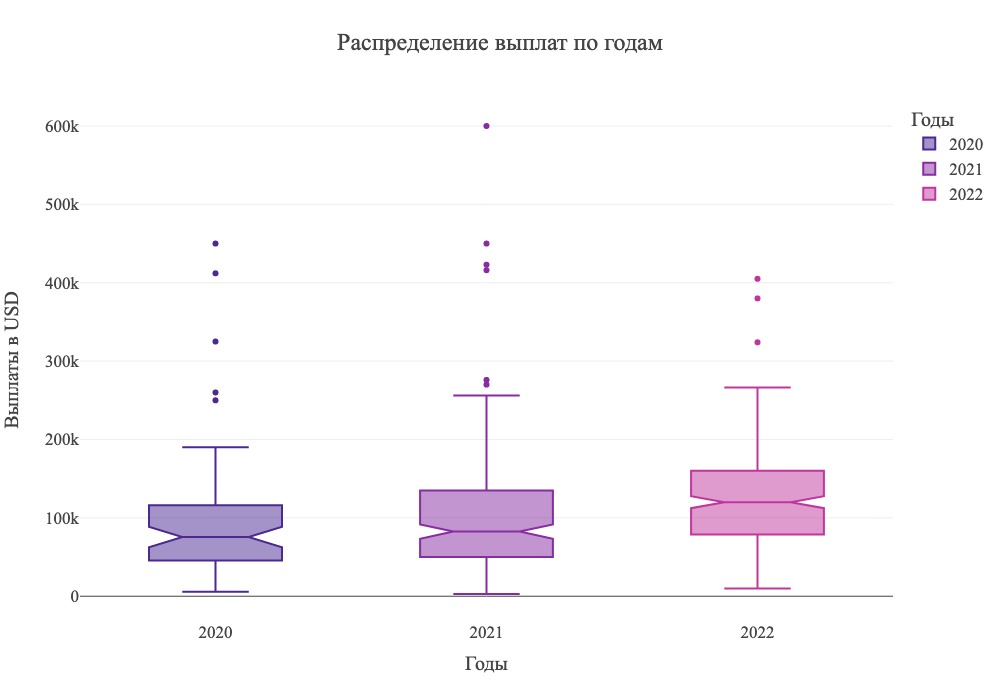

In [973]:
# Посмотрим распределение зарплаты в разерезе по годам - используем боксплот
# График
fig = px.box(data, 
                y = 'salary_in_usd', 
                x = 'work_year', 
                title = 'Распределение выплат по годам',
                color = 'work_year',
                color_discrete_sequence = px.colors.sequential.Agsunset,
                template = 'presentation',
                labels={'salary_in_usd':'Выплаты в USD', 
                        'work_year':'Годы', 'color':'Годы'},
                notched=True,
                height = 700, 
                width = 1000
            )

# Настройка шрифта 
fig.update_layout(font = dict(size=17,family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/013_salary_mean_year_box.html")

In [262]:
# Сделаем таблицу и посмотрим скомпанованные данные
data_agg_year = data.groupby('work_year')['salary_in_usd'].describe().round(2)
data_agg_year

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,278.0,123089.10,59888.93,10000.0,78791.0,120000.0,160000.0,405000.0


<hr style="border-style: dashed;">

__Вывод:__   
Как мы видим медианы у нас не совпадают, среднее также отличается, и мы можем утверждать, что размер выплат с годами становяться больше. Для определения являеться ли параметр __work_year__ статистически значемым, мы проведем статистическое тестирование в следующем разделе.  

Также хочу отметить, что количество выбросов становится меньше. Есть понимание на 'рынке' сколько стоит специалист и происходит насыщение 'рынка' ?
<hr style="border-style: dashed;">

#### Выплаты в зависимости от отпыта работы (experience_level, salary_in_usd)

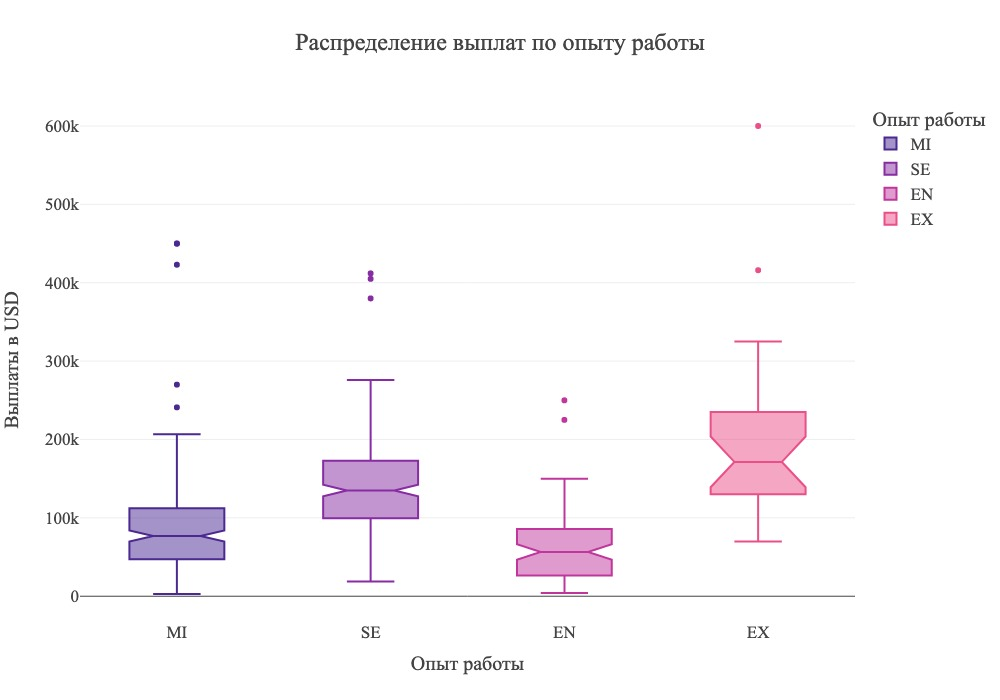

In [974]:
# Посмотрим распределение зарплаты в разерезе по опыту работы - используем боксплот
# График
fig = px.box(data, 
                y = 'salary_in_usd', 
                x = 'experience_level', 
                title = 'Распределение выплат по опыту работы',
                color = 'experience_level',
                color_discrete_sequence = px.colors.sequential.Agsunset,
                template = 'presentation',
                labels={'salary_in_usd':'Выплаты в USD', 
                    'experience_level':'Опыт работы', 'color':'Опыт работы'},
                notched=True,
                height = 700, 
                width = 1000
            )

# Настройка шрифта 
fig.update_layout(font = dict(size=17,family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/014_salary_experience_box.html")

In [267]:
# Сделаем таблицу и посмотрим скомпанованные данные
data_agg_experience = data.groupby('experience_level')['salary_in_usd'
                                                      ].describe().round(2)
data_agg_experience

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.00,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.50,171437.5,233750.00,600000.0
MI,208.0,87793.00,64118.97,2859.0,47163.75,76940.0,112075.00,450000.0
SE,243.0,138374.88,59955.97,18907.0,99531.50,135000.0,171881.00,412000.0


<hr style="border-style: dashed;">

__Вывод:__  
Здесь как видим значения зарпплаты отличаються в зависимости от уровня опыта, об этом нам говорит график и таблица. Для определения являеться ли параметр __experience_level__ статистически значемым, мы проведем статистическое тестирование в следующем разделе.  

Также хочу отметить, что здесь мы видим, наименьшее минимальное значение у Мидла, а не у Джуна - возможно это связанно с формой работы, размером компаний или локацией нахождения.
<hr style="border-style: dashed;">

#### Выплаты в зависимости от типа занятости (employment_type, salary_in_usd)

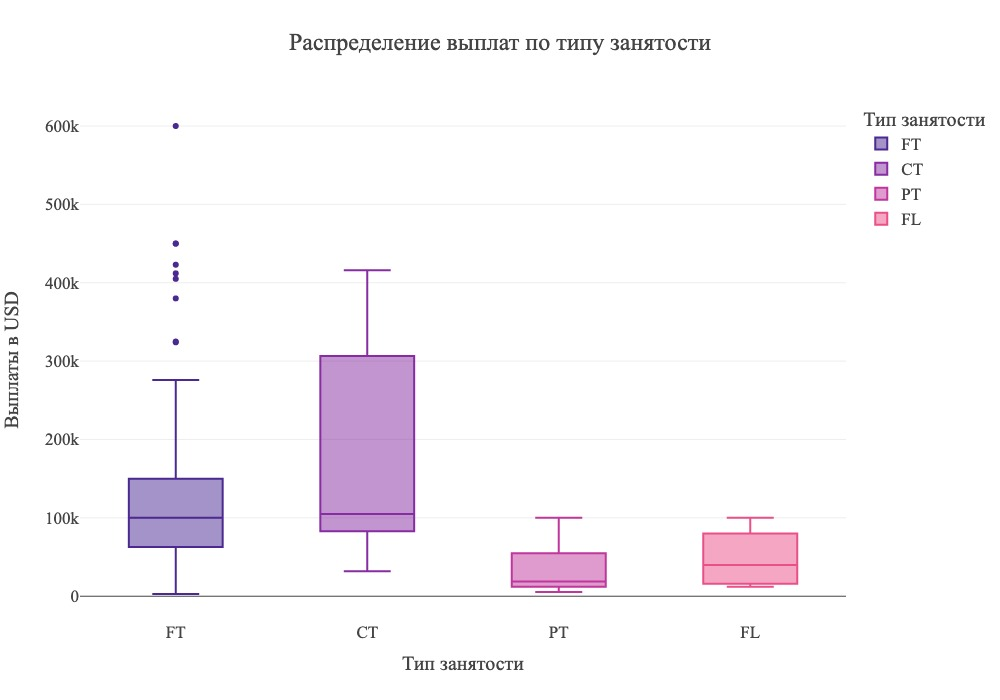

In [975]:
# Посмотрим распределение зарплаты в разерезе по типу занятости - используем боксплот
# График
fig = px.box(data, 
                y = 'salary_in_usd', 
                x = 'employment_type', 
                title = 'Распределение выплат по типу занятости',
                color = 'employment_type',
                color_discrete_sequence = px.colors.sequential.Agsunset,
                template = 'presentation',
                labels={'salary_in_usd':'Выплаты в USD', 
                        'employment_type':'Тип занятости', 
                        'color':'Тип занятости'
                        },
                height = 700, 
                width = 1000
            )

# Настройка шрифта 
fig.update_layout(font = dict(size=17,family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/015_salary_employment_box.html")

In [976]:
# Сделаем таблицу и посмотрим скомпанованные данные
data_agg_employment = data.groupby('employment_type')['salary_in_usd'
                                                      ].describe().round(2)
display(data_agg_employment)

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.0,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.0,40000.0,70000.0,100000.0
FT,546.0,111811.84,70790.70,2859.0,62726.0,100000.0,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.0,18817.5,48370.0,100000.0


<hr style="border-style: dashed;">

__Вывод:__   
Как видно из графика и таблицы здесь также у нас отличаються значение зарплаты в зависимости от типа занятости. Для определения являеться ли параметр __employment_type__ статистически значемым, мы проведем статистическое тестирование в следующем разделе.

Также хочу отметить, что здесь в FT (полный рабочий день), наименьшая заработная плата (у мидла) - видимо здесь размер фирмы играет значение либо локаций.   
Выбросы у нас присутствуют только в категорий FT (полный рабочий день).
<hr style="border-style: dashed;">

#### Выплаты в зависимости от должности (job_title, salary_in_usd)

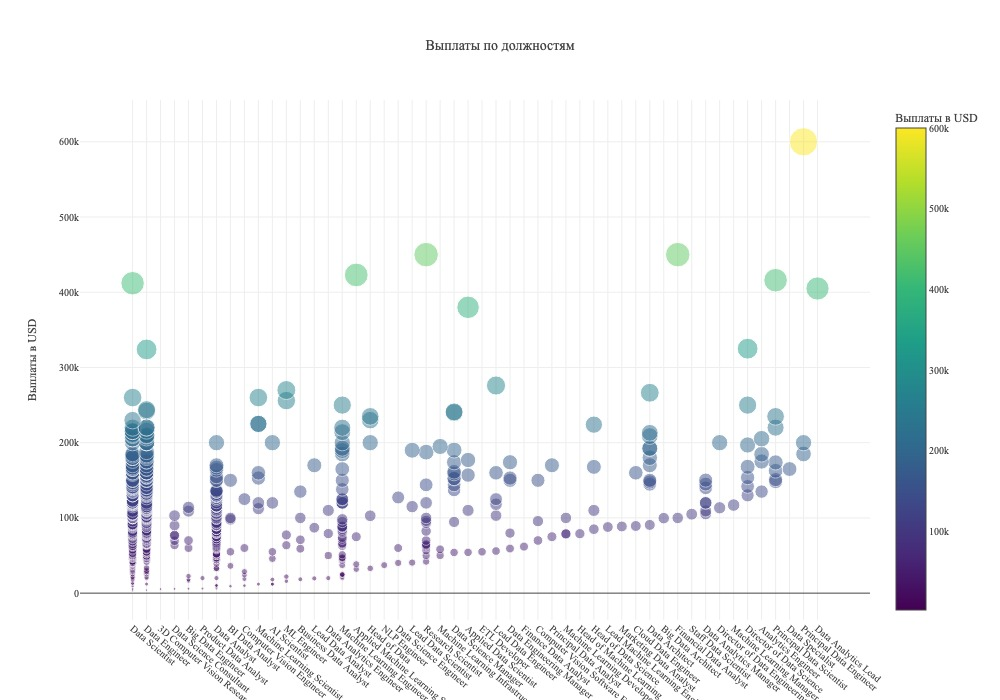

In [977]:
# Покажем взаимосвязь выплат и должности - используем scatter
data_job = pd.DataFrame(data[['job_title', 'salary_in_usd']])
# Для боллее четкой видимости взаимосвязи отсортируем по размеру выплат
data_job = data_job.sort_values(by='salary_in_usd')

# График
fig = px.scatter(data_job, 
                 x='job_title', 
                 y='salary_in_usd',
                 title = 'Выплаты по должностям',
                 color = 'salary_in_usd',
                 template = 'presentation',
                 size='salary_in_usd',
                 opacity = 0.5,
                 height = 700,
                 width = 1000,
                 labels={'salary_in_usd':'Выплаты в USD',
                         'job_title':''
                        }
                 )

# Настройка шрифта и наклона категорий оси х
fig.update_layout(xaxis_tickangle=40, 
                  font = dict(size=10, family="TimesNewRoman")
                 )

fig.show('jpeg')
#fig.write_html("data/plotly/016_salary_job_scatter.html")

In [979]:
# посмотрим зарплаты выше 300 000
display(data_job[data_agg_job['salary_in_usd'] > 300000])

,job_title,salary_in_usd
461,Data Engineer,324000
25,Director of Data Science,325000
498,Applied Data Scientist,380000
502,Data Analytics Lead,405000
63,Data Scientist,412000
224,Principal Data Scientist,416000
157,Applied Machine Learning Scientist,423000
33,Research Scientist,450000
97,Financial Data Analyst,450000
251,Principal Data Engineer,600000


<hr style="border-style: dashed;">

__Вывод:__
Как мы видим выше 300 000 получают зарплату всего лишь 10 вакансий из них 'базовые' - Data Engineer, Data Scientis. Остальные это какие либо специализации, которые приобретаються с опытом. 
Также мы можем заметить на таблице, чем 'специализированее' становится вакансия, тем больше предлагают ЗП, самые низкие зарплатные позиций - Data Engineer, Data Scientis.   
Здесь полагаю надо учитывать специфику должности в компаниях, а также размер компаний и ее местонахождение. Так как мы наблюдали одинаковый должности с одинаковыми зарплатами - возможно это все в одной компаний или в разных ?.   

Мы можем сделать вывод, что в зависимости от должности, зарплата отличаеться. Для определения является ли параметр __job_title__ статистически значимым, мы проведем статистическое тестирование.

<hr style="border-style: dashed;">

#### Выплаты в зависимости от кода валюты (salary_currency, salary_in_usd)

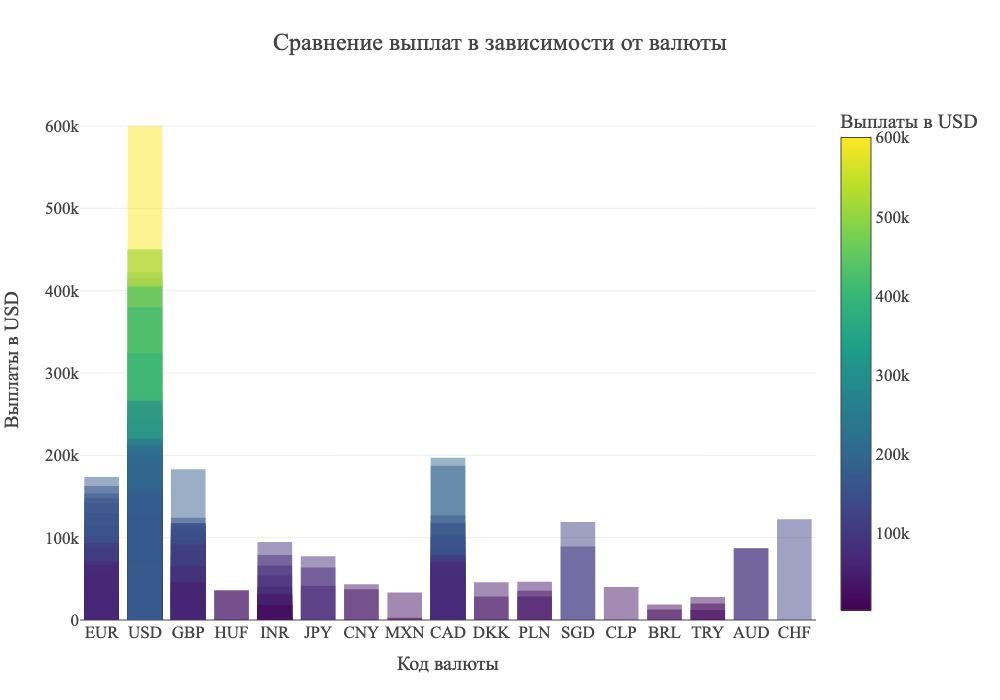

In [988]:
# Посмотрим сравнение зарплат в зависимости от валюты
# График
fig = px.bar(data,
                x = 'salary_currency',
                y = 'salary_in_usd', 
                color = 'salary_in_usd',
                color_discrete_sequence = px.colors.sequential.Agsunset,
                title = 'Сравнение выплат в зависимости от валюты',
                template = 'presentation',
                labels = {'salary_in_usd':'Выплаты в USD', 
                          'salary_currency':'Код валюты'},
                barmode='overlay',
                height = 700,
                width = 1000,
            )

# Настройка шрифта и наклона категорий оси х
fig.update_layout(font = dict(size=17, family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/017_salary_currency_bar.html")

In [980]:
data_currency = data.groupby('salary_currency')['salary_in_usd'
                                               ].describe().round(2)
display(data_currency)

,count,mean,std,min,25%,50%,75%,max
salary_currency,,,,,,,,
AUD,2.0,87064.00,510.53,86703.0,86883.50,87064.0,87244.50,87425.0
BRL,2.0,15904.00,4246.88,12901.0,14402.50,15904.0,17405.50,18907.0
CAD,18.0,97222.89,40724.80,52396.0,71130.50,83264.5,113750.75,196979.0
CHF,1.0,122346.00,NaN,122346.0,122346.00,122346.0,122346.00,122346.0
CLP,1.0,40038.00,NaN,40038.0,40038.00,40038.0,40038.00,40038.0
CNY,2.0,40283.50,4309.82,37236.0,38759.75,40283.5,41807.25,43331.0
DKK,2.0,37252.50,12223.75,28609.0,32930.75,37252.5,41574.25,45896.0
EUR,93.0,65598.91,31292.37,10354.0,46759.00,62649.0,79197.00,173762.0
GBP,43.0,81744.12,30084.12,37300.0,57575.00,78526.0,103931.00,183228.0


<hr style="border-style: dashed;">

__Вывод:__   
На графике видно, что выплаты выше 200 000 получают только в американских долларах (USD), выплаты выше 100 000 получают также в евро (EUR), британских фунтах (GBR), канадских долларах (CAD), сингапурский доллар (SGD), щвейцарский франк (CHF). В остальных валютах размер выплат меньше. Мы можем сделать вывод, что в зависимости от кода валюты размер выплат может отличаться. Для определения является ли параметр __salary_currency__ статистически значимым, мы проведем статистическое тестирование. 

Также мы можем здесь видеть, что самую минимальную выплату (2859 usd) получают в мексиканских песо (MXN), а самую максимальную (600k usd) в американских долларах (USD).    
Обратите внимание на цветовую дифференциацию, мы видим, что в среднем зарплаты в USD начинаються в районе 137k usd.  

<hr style="border-style: dashed;">

####   Выплаты в зависимости от основной страны проживания сотрудника в течение рабочего года (employee_residence, salary_in_usd)

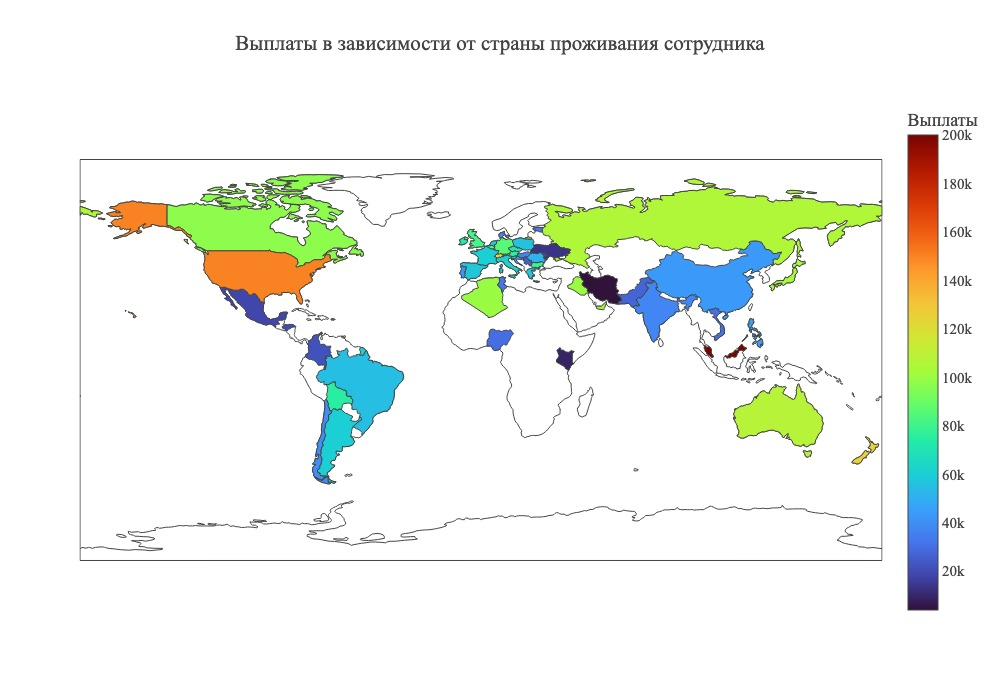

In [990]:
# Посмотрим зависимость выплат от распределения по странам проживания сотрудников.
# Подготовим таблицу для графика - сгрупируем по странам, и вычислим среднию выплату
data_employee_residence = pd.DataFrame(data.groupby('employee_residence')[
                            'salary_in_usd'].mean().round().reset_index())

# С помощью библиотеки coco преобразуем названия стран
data_employee_residence['short_name'] = coco.convert(
    names=data_employee_residence['employee_residence'], to="short_name")

# График
fig = px.choropleth(locations = data_employee_residence['short_name'],
                    locationmode='country names',
                    color = data_employee_residence['salary_in_usd'],
                    color_continuous_scale = px.colors.sequential.Turbo,
                    template = 'presentation',
                    title = 'Выплаты в зависимости от страны проживания сотрудника',
                    height = 700, 
                    width = 1000,
                    labels={'color':'Выплаты'}
                   )


# Настройки шрифта
fig.update_layout(font = dict(size= 15, family="TimesNewRoman"),
                 )

fig.show('jpeg')
#fig.write_html("data/plotly/018_employee_residence_salary_choropleth.html")

<hr style="border-style: dashed;">

__Вывод:__   
На графике у нас видно, что страна проживания сотруднкика влияет на выплаты, но с другой стороны мы помним, что количество резидентов может быть не сопостовима на порядок или два, так-как в США проживает 295 человек, а в Малазий 1. Поэтому для определения является ли параметр __employee_residence__ статистически значимым, мы проведем статистическое тестирование.

<hr style="border-style: dashed;">

####  Выплаты в зависимости от типа работы (remote_ratio, salary_in_usd).

- 0 - без удаленной работы
- 50 - частично удаленная работа
- 100 - удаленная работа

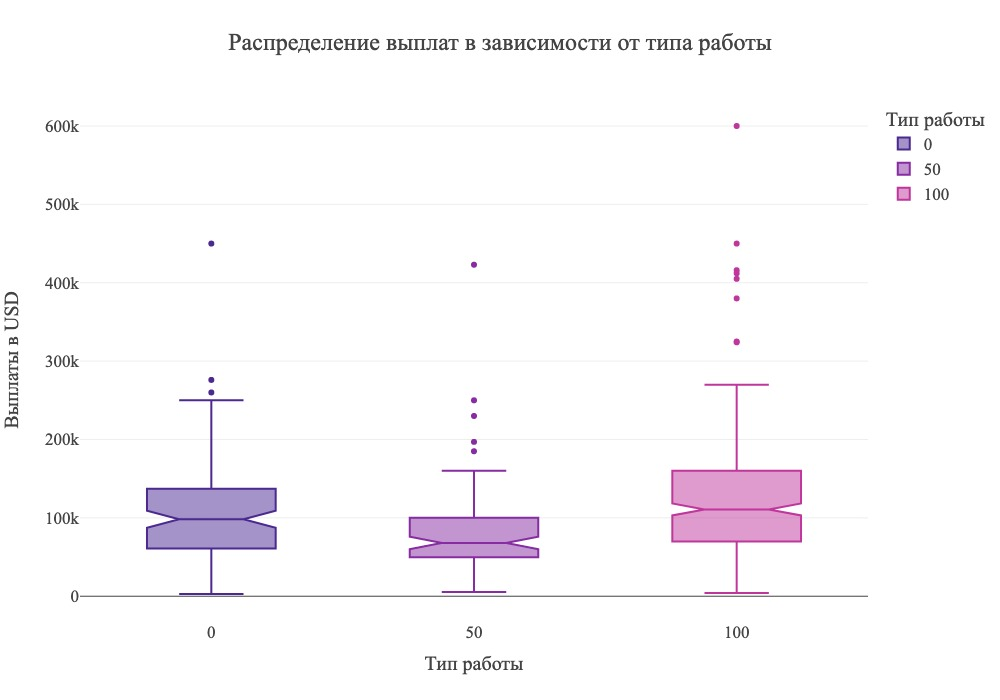

In [986]:
# График
fig = px.box(data, 
                y = 'salary_in_usd', 
                x = 'remote_ratio', 
                title = 'Распределение выплат в зависимости от типа работы',
                color = 'remote_ratio',
                color_discrete_sequence = px.colors.sequential.Agsunset,
                template = 'presentation',
                labels={'salary_in_usd':'Выплаты в USD', 
                        'decoding':'Тип работы', 
                        'remote_ratio':'Тип работы',
                        },
                notched=True,
                height = 700, 
                width = 1000,
            )

# Настройка шрифта 
fig.update_layout(font = dict(size=17,family="TimesNewRoman"))


fig.show('jpeg')
#fig.write_html("data/plotly/019_salary_rr_box.html")

In [983]:
# Посмотрим таблицу
remote_ratio = data.groupby('remote_ratio')['salary_in_usd'
                                           ].describe().round(2)
display(remote_ratio)

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,121.0,105785.40,68392.50,2859.0,62000.0,98158.0,136000.00,450000.0
50,98.0,80721.90,57639.10,5409.0,50000.5,68010.5,99925.75,423000.0
100,346.0,120763.19,74930.43,4000.0,70000.0,110712.5,159750.00,600000.0


<hr style="border-style: dashed;">

__Вывод:__   
На графике видно, что при разном типе работ разные выплаты, это мы можем наблюдать и в приведенной таблице, следовательно можем заключить что данный параметр влияет на выплаты. Для определения является ли __remote_ratio__ статистически значимым, мы проведем статистическое тестирование.

Отмечу, что без удаленной работы количество выбросов самое минимальное, а дальше идет по нарастающей.  
Также видно, что самый меньший диапазон выплат (в основном теле бокса) это в группе с частично удаленной работой - возможно они не успевают все сделать на работе и берут работу на дом ?

<hr style="border-style: dashed;">

#### Выплаты в зависимости от страны расположения компаний (главного офиса) (company_location, salary_in_usd)

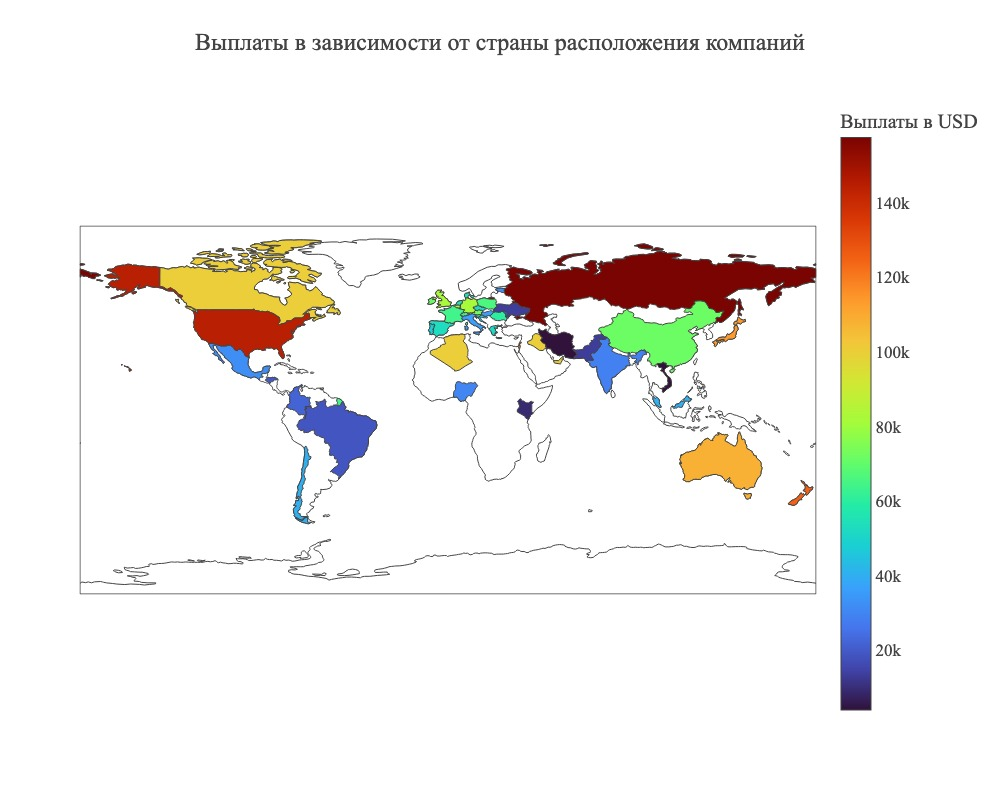

In [866]:
# Посмотрим зависимость выплат от распределения по странам расположения компаний.
# Подготовим таблицу для графика - сгрупируем по странам, и вычислим среднию выплату
data_company = pd.DataFrame(data.groupby('company_location')[
                            'salary_in_usd'].mean().round().reset_index())

# С помощью библиотеки coco преобразуем название стран
data_company['short_name'] = coco.convert(
    names=data_company['company_location'], to="short_name")


# График
fig = px.choropleth(locations = data_company['short_name'] ,
                    locationmode='country names',
                    color = data_company['salary_in_usd'],
                    color_continuous_scale = px.colors.sequential.Turbo,#sequential.Agsunset,
                    template = 'presentation',
                    title = 'Выплаты в зависимости от страны расположения компаний',
                    height = 800, 
                    width = 1000,
                    labels={'color':'Выплаты в USD'}
                   )

# Настройки шрифта
fig.update_layout(font = dict(size= 17, family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/020_salary_location_choropleth.html")

<hr style="border-style: dashed;">

__Вывод:__   
Как видим карта нахождения компаний у нас отличаеться от карты проживания сотрудников как по форме, так и по наполнению. Стабильными у нас здесь остаються +/- США и Европа (сравнивая проживания сотрудников и нахождения компаний). И судя по цветовой дифференций это будет у нас важный признак для выплат (хотя помним про количество компаний). Для определения является ли __company_location__ статистически значимым, мы проведем статистическое тестирование.

Также хочу отметить, что в лидерах по выплате - здесь мы видим РФ.

<hr style="border-style: dashed;">

####  Выплаты в зависимости от размера компаний (company_size, salary_in_usd)

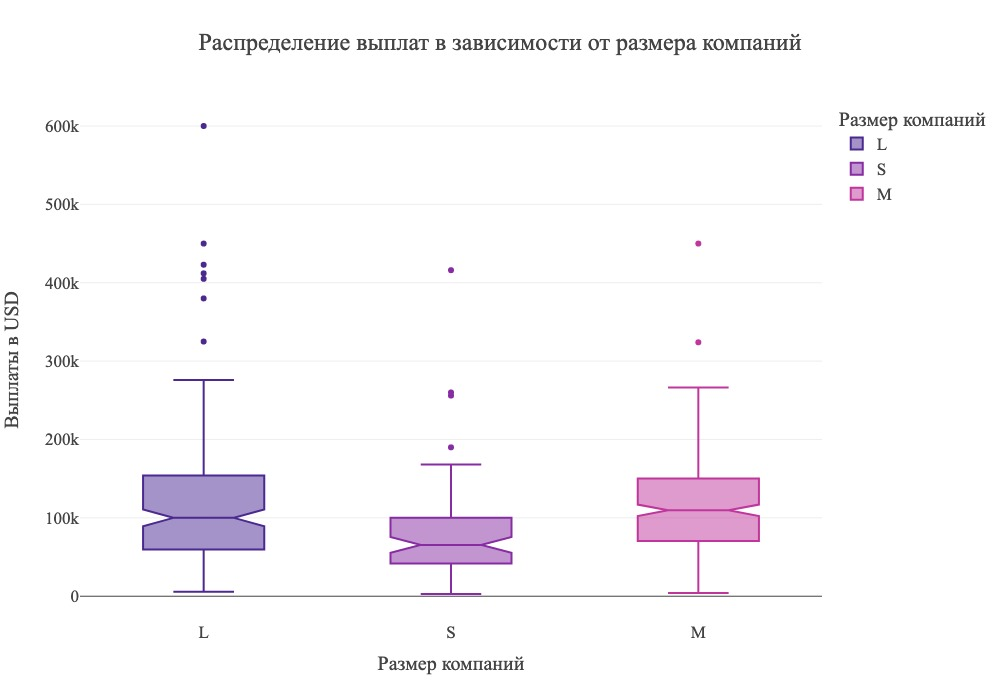

In [927]:
# Посмотрим на распределение выплат в разрезе размера компаний - box
# График
fig = px.box(data, 
                y = 'salary_in_usd', 
                x = 'company_size', 
                title = 'Распределение выплат в зависимости от размера компаний',
                color = 'company_size',
                color_discrete_sequence = px.colors.sequential.Agsunset,
                template = 'presentation',
                labels={'company_size':'Размер компаний',
                        'salary_in_usd':'Выплаты в USD'
                       },
                height = 700, 
                width = 1000,
                notched=True
            )

# Настройка шрифта 
fig.update_layout(font = dict(size=17,family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/021_salary_company_size_box.html")

In [987]:
# Посмотрим на таблицу 
data_agg_size = data.groupby('company_size')['salary_in_usd'].describe()
display(data_agg_size)

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,193.0,118213.880829,86753.270985,5882.0,60000.0,100000.0,153667.00,600000.0
M,290.0,114807.079310,60779.043553,4000.0,70821.5,109640.0,150213.75,450000.0
S,82.0,77872.097561,63814.516062,2859.0,41816.0,65511.0,100000.00,416000.0


<hr style="border-style: dashed;">

__Вывод:__   
Как мы видим, у нас выплаты для больших и средних компаний почти одинаковы, а вот выплаты в малых компаниях отличаються на графике. Для понимания является ли __company_size__ статистически значимым, мы проведем статистическое тестирование.

Также мы видим, что самое большое количество выбросов наблюдаеться в больших компаниях, они могут платить специалистам в не рынка ?

<hr style="border-style: dashed;">

***

__Подведем итог__  
Итак мы видим на графиках, что на выплаты влияют следующие столбцы: год выплат (work_year), опыт работы (experience_level), тип занятости (employment_type - но здесь у нас доминирует полный день), должность (job_title - но здесь сильное влияние оказывает опыт работы), код валюты (salary_currency - но здесь сильное влияние оказывает страна проживания), страна проживания сотрудника (employee_residence - здесь возможно пересечение с местонахождением компаний), тип работы (remote_ratio), местонахождение компаний (company_location), размер компаний (company_size - но как видим только для малых компаний)). Как видим только 2 столбца влияют сами по себе (work_year, experience_level), остальные оказывают влияние, но с какими либо оговорками.

***

#### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
Частично на этот вопросы мы ответили когда смотрели выплаты по годам, где увидели, что количество выплат увеличиваеться каждый год, напомню на 2022 приходиться около 50% выплат.

In [1128]:
DS = data[data['job_title'] == 'Data Scientist']
display(DS)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
7,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
10,2020,EN,FT,Data Scientist,45000,EUR,51321,FR,0,FR,S
11,2020,MI,FT,Data Scientist,3000000,INR,40481,IN,0,IN,L
12,2020,EN,FT,Data Scientist,35000,EUR,39916,FR,0,FR,M
...,...,...,...,...,...,...,...,...,...,...,...
530,2022,SE,FT,Data Scientist,140400,USD,140400,US,0,US,M
539,2022,SE,FT,Data Scientist,210000,USD,210000,US,100,US,M
553,2022,SE,FT,Data Scientist,150000,USD,150000,US,100,US,M
556,2022,MI,FT,Data Scientist,160000,USD,160000,US,100,US,M


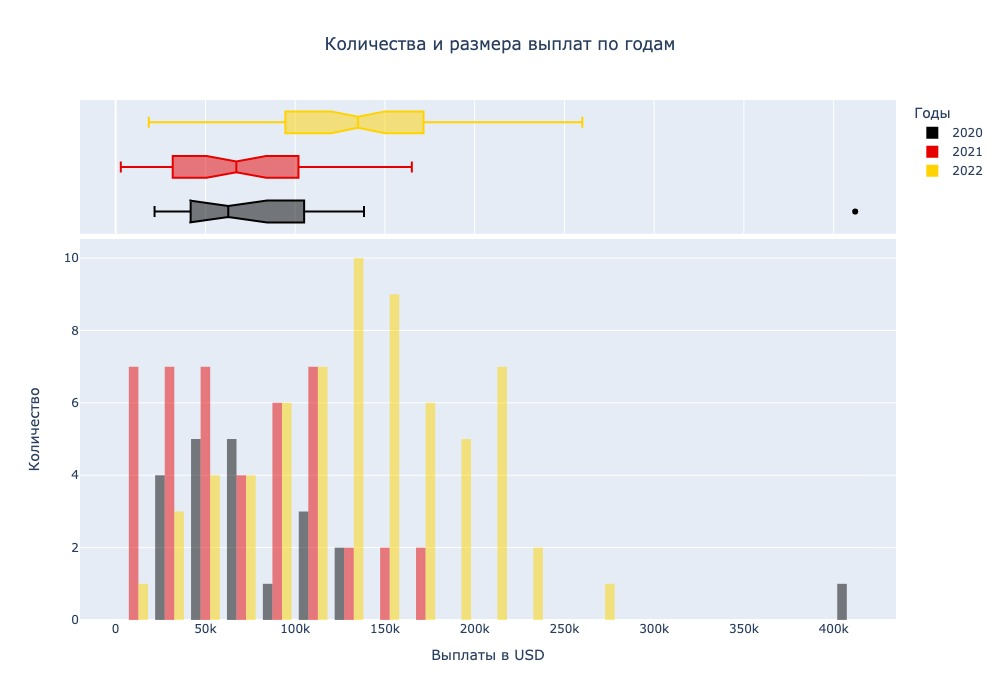

In [1129]:
# График
fig = px.histogram(DS, 
                    x="salary_in_usd", 
                    color="work_year",
                    color_discrete_sequence=px.colors.sequential.Hot,
                    width = 1000, 
                    height = 700, 
                    marginal='box',
                    opacity=0.5,
                    barmode='group',
                    title='Количества и размера выплат по годам',
                    labels={'work_year':'Годы'}
                  )

# Обновим данные для осей и названия
fig.update_layout(title_x = 0.5,
                    xaxis_title="Выплаты в USD", 
                    yaxis_title="Количество",
                 )



fig.show('jpeg')
#fig.write_html("data/plotly/Year-on-year_growth_salary_HistBox.html")

In [1132]:
display(DS.groupby('work_year')['salary_in_usd'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


<hr style="border-style: dashed;">

__Вывод:__  
Как видно по графику количество и размер выплат с каждым годом растет:
- в 2020 году - большая часть специалистов получала выплаты от 41.7k до 105k с медианной - 62.7k 
- в 2021 году - уже от 31.7k до 101.8k с медианной - 67.2k
- в 2022 году - от 94.5k до 171.5k с медианной - 135k
- также мы видим, что выбросы у нас присутствуют только в 2020 году (412k)    

На основание данного графика, мы можем дать положительный ответ на наш вопрос. Особенно большой рост был в 2022 году. Но являеться ли этот рост статистически значимыми, мы определим после проведения статистического теста в следующем разделе.

<hr style="border-style: dashed;">

#### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Для того, чтобы пответить на вопрос - мы сравним зарплаты с помощью гистограммы и посмотрим распределение с помощью box.

In [1125]:
# Для начала выделим данные по должностям и году
DS_DE = data[((data['job_title'] == 'Data Scientist') | (data['job_title'
                        ] == 'Data Engineer')) & (data['work_year'] == 2022)]

display(DS_DE)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
287,2022,SE,FT,Data Engineer,135000,USD,135000,US,100,US,M
290,2022,MI,FT,Data Scientist,130000,USD,130000,US,0,US,M
291,2022,MI,FT,Data Scientist,90000,USD,90000,US,0,US,M
292,2022,MI,FT,Data Engineer,170000,USD,170000,US,100,US,M
293,2022,MI,FT,Data Engineer,150000,USD,150000,US,100,US,M
...,...,...,...,...,...,...,...,...,...,...,...
553,2022,SE,FT,Data Scientist,150000,USD,150000,US,100,US,M
556,2022,MI,FT,Data Scientist,160000,USD,160000,US,100,US,M
557,2022,MI,FT,Data Scientist,130000,USD,130000,US,100,US,M
560,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M


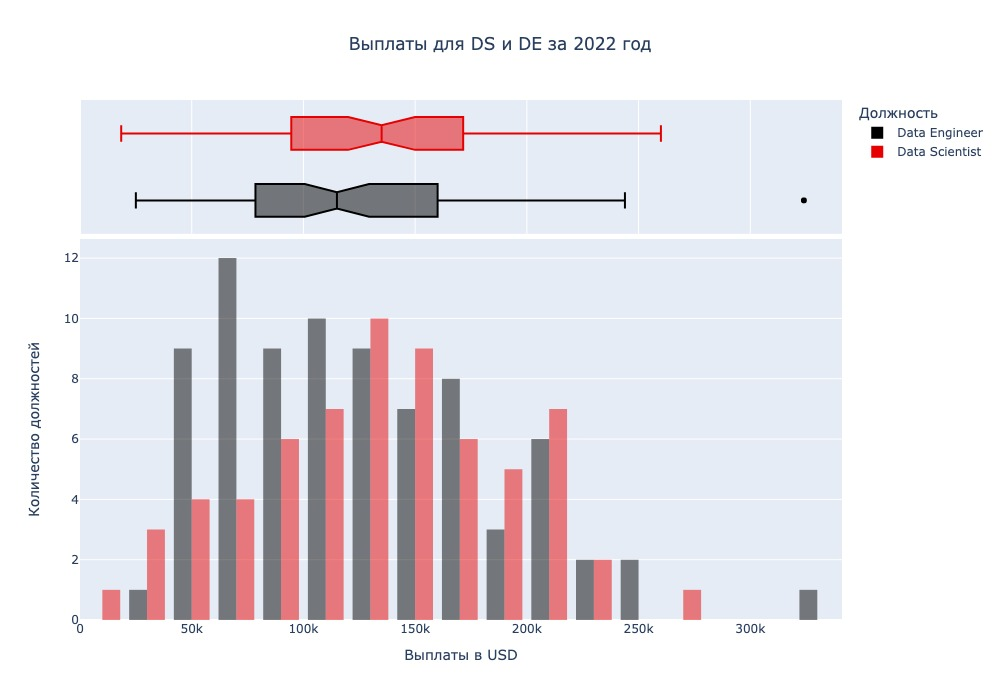

In [1126]:
# График
fig = px.histogram(DS_DE, 
                    x="salary_in_usd", 
                    color="job_title",
                    color_discrete_sequence=px.colors.sequential.Hot,
                    width = 1000, 
                    height = 700, 
                    marginal='box',
                    opacity=0.5,
                    barmode='group',
                    title='Выплаты для DS и DE за 2022 год',
                    labels={'job_title':'Должность'}
                  )

# Обновим данные для осей и названия
fig.update_layout(title_x = 0.5,
                    xaxis_title="Выплаты в USD", 
                    yaxis_title="Количество должностей",
                 )

fig.show('jpeg')
#fig.write_html("data/plotly/correlation_salary_DS_DE_HistBox.html")

In [1127]:
display(DS_DE.groupby('job_title')['salary_in_usd'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,79.0,124651.78,57846.84,25000.0,78526.0,115000.0,160040.0,324000.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


<hr style="border-style: dashed;">

__Вывод:__   
- По графику и таблице мы видим, что минимальная выплата DS (18.4k) меньше, чем у DE (25k), но зато максимальная выплата у DS (260k) больше чем у DE (243.9k). 
- Однако у DE есть выброс в оплате в 324k.
- Если сравнивать среднее и медиану (они не совпадают - не нормальное распределение), то здесь у DS цифры больше. 
- Если смотреть на среднее, то мы можем сказать выплаты DE около 48.6%, а выплаты для DS около 51.4%, от общей средней выплаты для данных должностей.Также мы видим, что средняя выплата DE это около 95% от средней выплаты  DS.  
- 50% DS получают выплаты от 94.5k до 171.5k
- 50% DE получают выплаты от 78.5k до 160k

Подводя итог мы можем сказать, что DS платят больше, чем DE. Чтобы определить, являются ли эти различия статистически значимыми, мы проведём статистические тесты.

<hr style="border-style: dashed;">

#### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?


In [479]:

# График
fig = px.bar(data20, 
                y='job_title',
                x='salary_in_usd', 
                title = 'Зарплата в зависимости от должности',
                color='salary_in_usd',
                #color_discrete_sequence=px.colors.sequential.Turbo,
                template='presentation',
                text_auto=True,
                width = 1000,
                orientation='h',
                labels={'job_title':'', 'salary_in_usd':'Зарплата в USD'}
            )

# настройка шрифтов и надписей
fig.update_layout(yaxis_tickangle=60, font = dict(size=10,
                                                  family="TimesNewRoman"))
fig.show()

In [619]:
data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
560,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
561,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
562,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
563,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [64]:
# Цветовые схемы
fig = px.colors.sequential.swatches()
fig.show()

In [66]:
# Цветовые схемы
fig = px.colors.qualitative.swatches()
fig.show()

In [674]:
# Темы по уомлчанию
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here

In [ ]:
data